In [1]:
from itertools import chain, combinations 
import pandas as pd
from sklearn import tree, linear_model

from data_loading import load_mibig_metadata, load_data
from prediction_utils import siderophore_preprocess, create_clf_data
from stability_utils import (fit_cross_val_and_plot_pr, 
                             visualize_tree_rules,
                             visualize_lasso_coeffs)

# Overview

If you haven't read `pfam_stability.ipynb` please do so, as this will use functionality from that notebook rather tersely. We will perform the same three basic analyses

1. Repeated Cross-Validation PR Curves
2. Stability analysis of rules
3. Stability analyses of lasso coefficients

This time, we will do it for _all_ possible featuresets and compare. 

In [2]:
meta = load_mibig_metadata()
datasets = load_data(meta)

Using 848 BGCs with both pfam and cath transporters, as well as Gram +/-.
Dataset pfam has 0 examples with all zeros.
Dataset cath has 0 examples with all zeros.
Dataset sbp has 759 examples with all zeros.
Dataset biosynthetic has 115 examples with all zeros.


# Demo of functions.

I've condensed the previous notebook into some functions to keep notebook bloat down. To demo, I'm going to just do G- siderophore prediction.

In [3]:
# Load data
full_pfam = datasets['pfam']
pfam = siderophore_preprocess(full_pfam, meta)
d = pfam.groupby('Gram').get_group(0)
X, y = create_clf_data(d)

# Create dict of classifiers
classifiers = {
    'tree': tree.DecisionTreeClassifier(max_depth=2, min_samples_split=3),
    'lasso': linear_model.LogisticRegression(penalty='l1', solver='liblinear')
}

The PR analysis is now in the `fit_cross_val_and_plot_pr` function. You can pass it a dict of any number of classifiers and it will plot them all, using the keys for the legend.

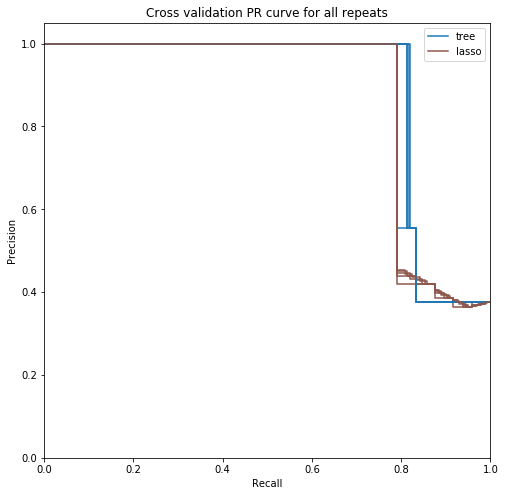

In [4]:
fit_cross_val_and_plot_pr(X, y, classifiers)

The rule visualization is now contained in the function `visualize_tree_rules`.

next


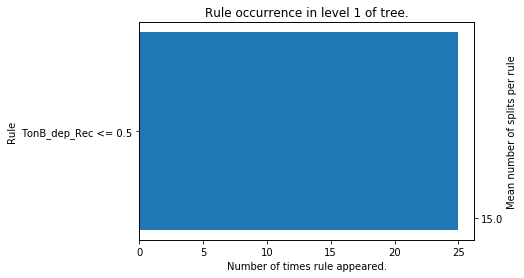

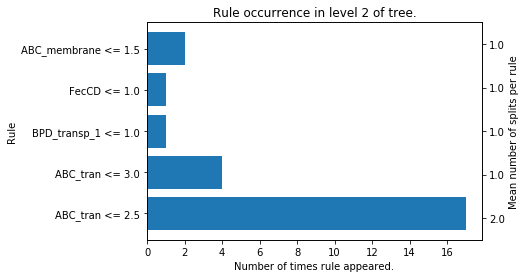

In [5]:
feature_names = d.columns.drop(['BGC', 'label', 'Gram'])
visualize_tree_rules(X, y, classifiers['tree'], feature_names)

Lastly, lasso visualization is now in `visualize_lasso_coeffs`.

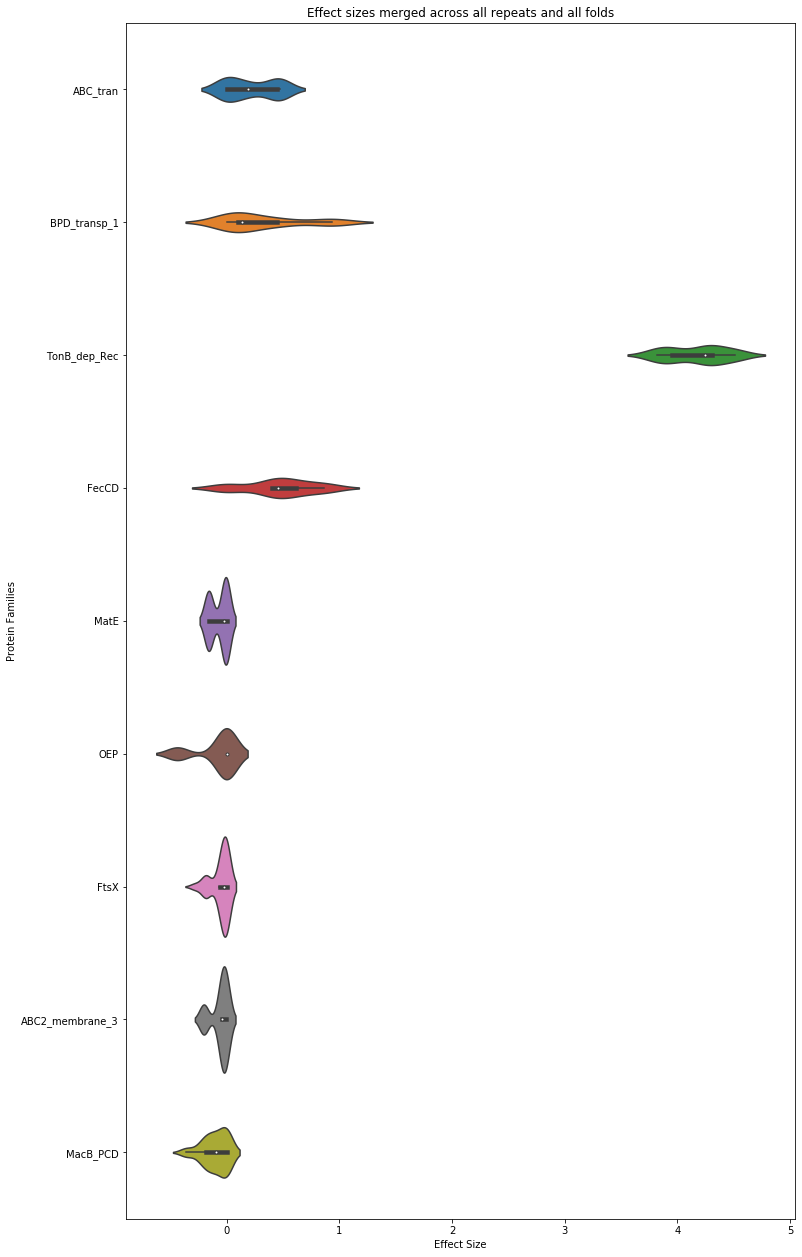

In [6]:
visualize_lasso_coeffs(X, y, classifiers['lasso'], feature_names)

# Siderophore analysis

Let's start with siderophore as always. We'll produce the above three plots for every subset of features available.

In [7]:
siderophore_data = {k: siderophore_preprocess(d, meta, verbose=True) for k, d in datasets.items()}

There are 257 examples for siderophore prediction.
Num positives: 39
Num negatives: 218
There are 257 examples for siderophore prediction.
Num positives: 39
Num negatives: 218
There are 257 examples for siderophore prediction.
Num positives: 39
Num negatives: 218
There are 257 examples for siderophore prediction.
Num positives: 39
Num negatives: 218


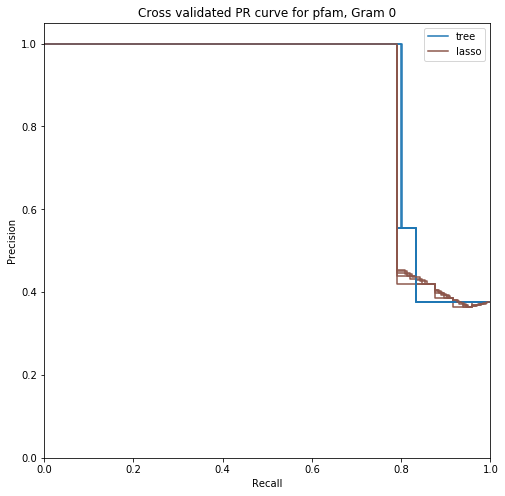

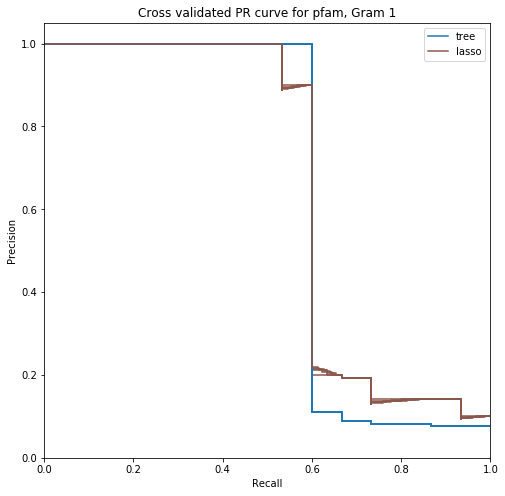

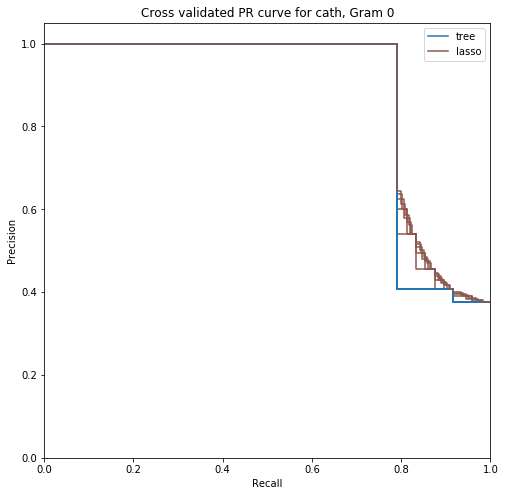

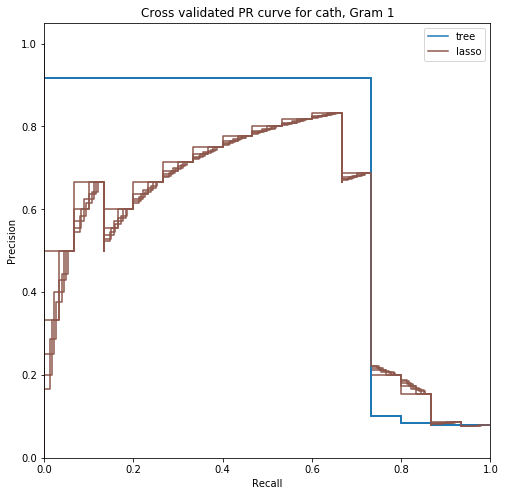

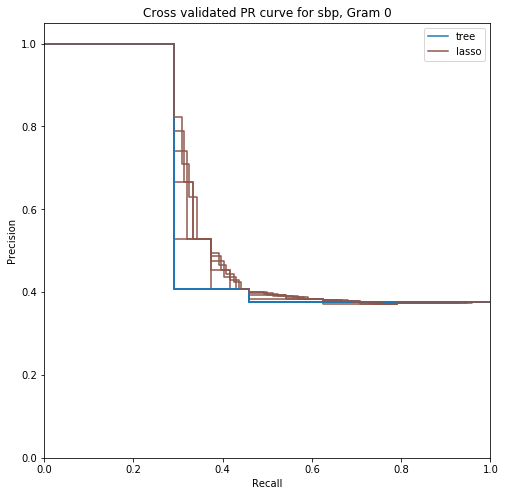

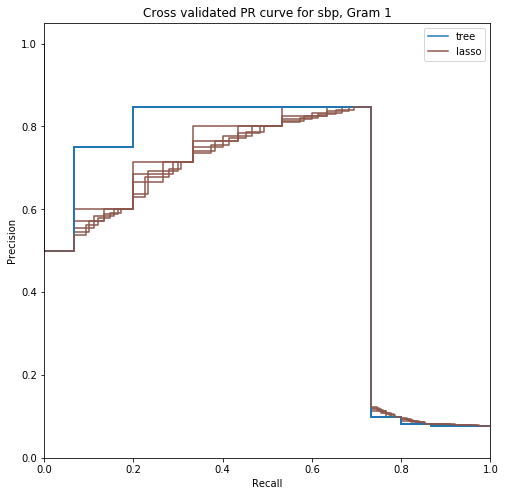

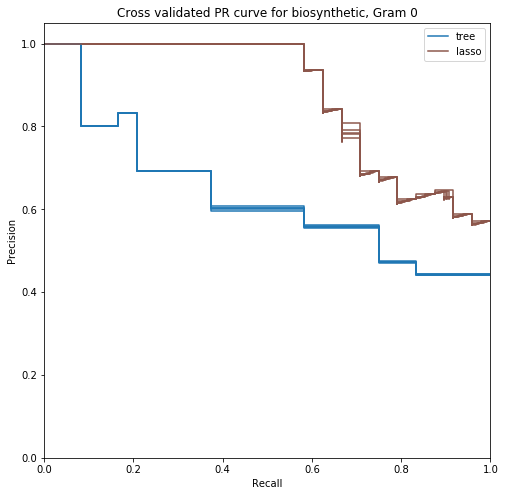

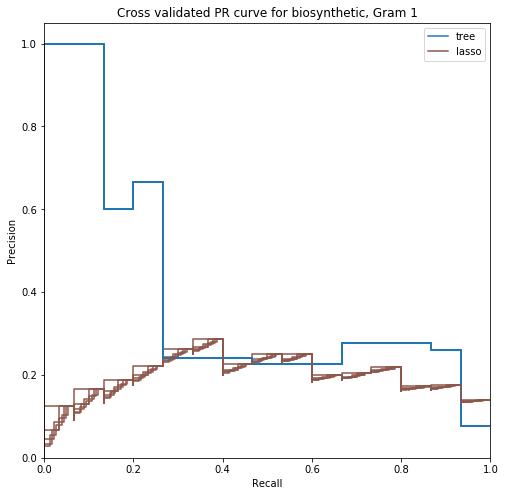

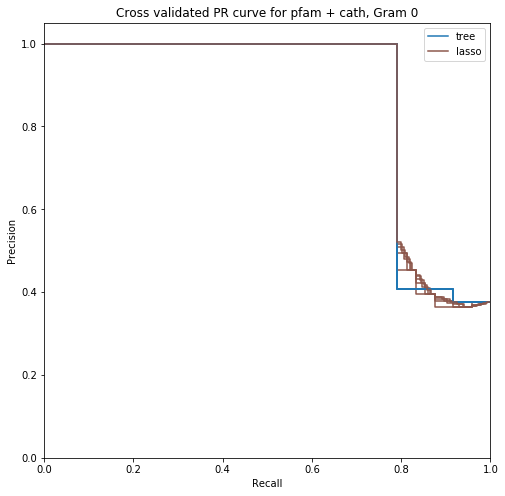

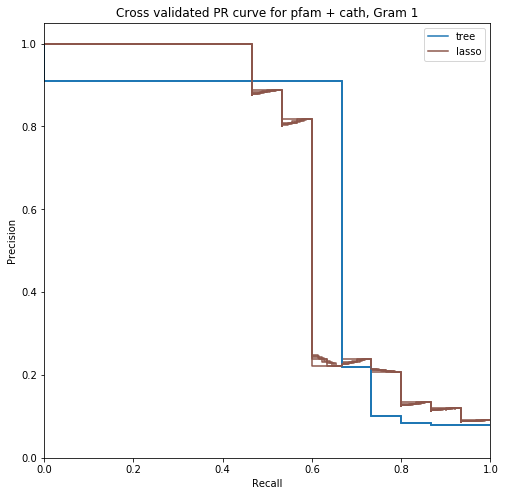

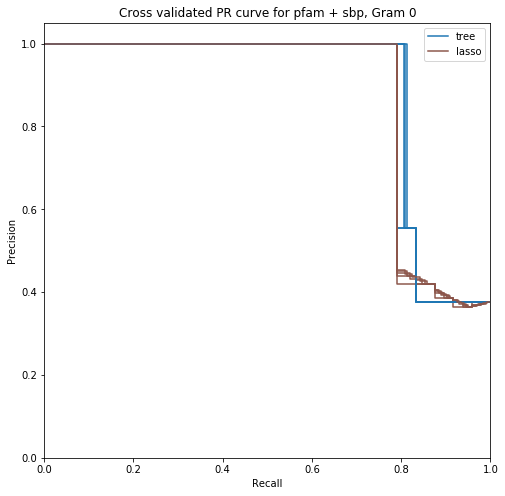

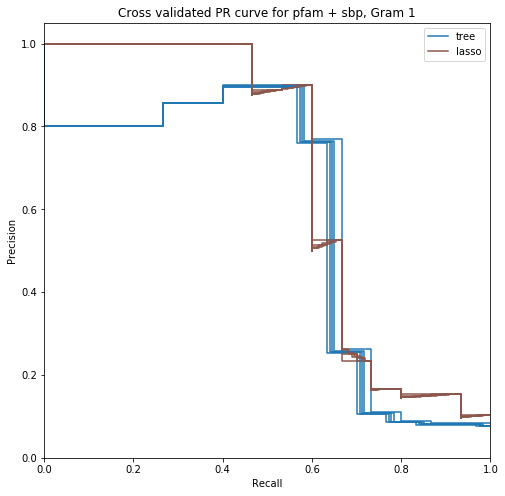

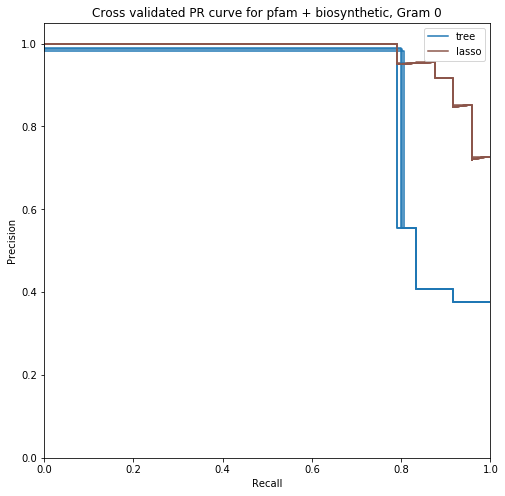

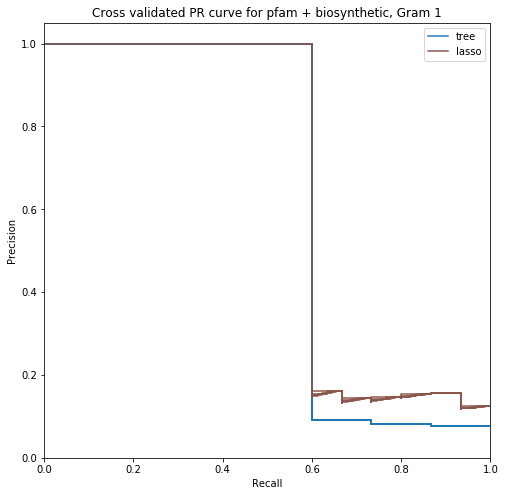

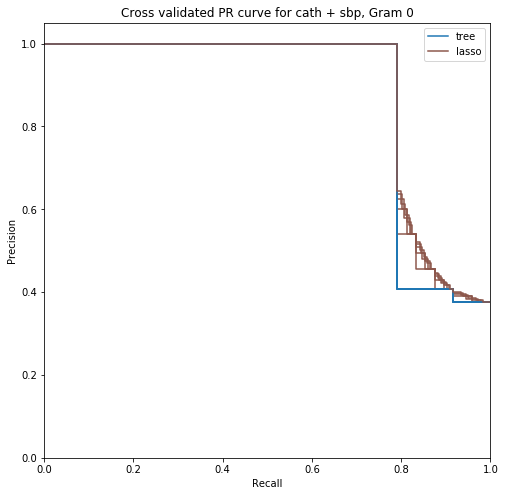

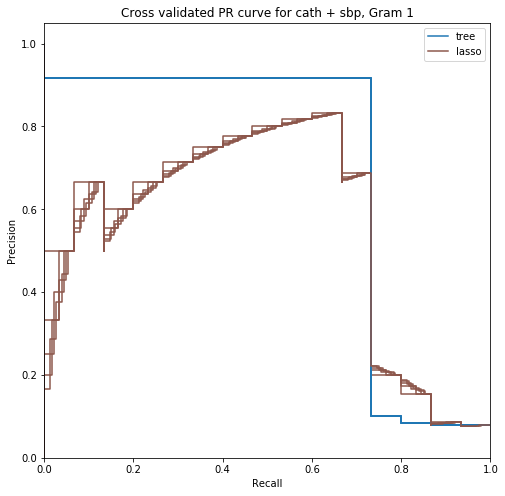

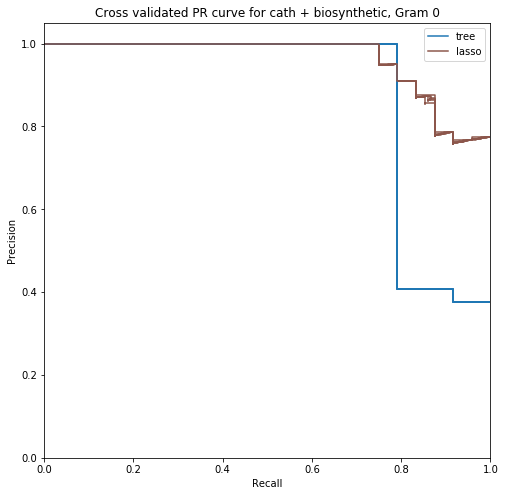

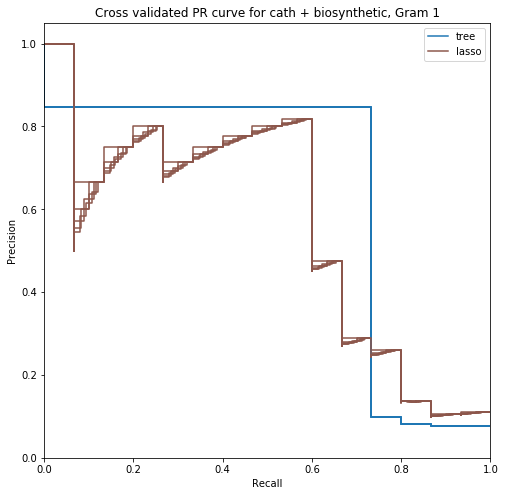

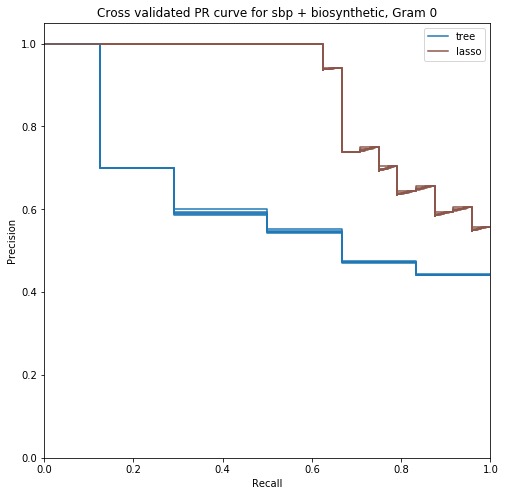

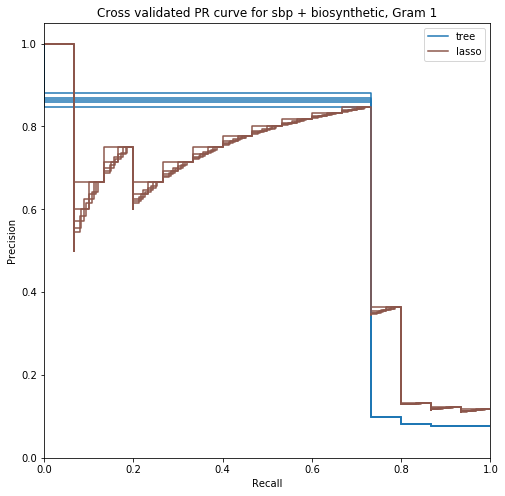

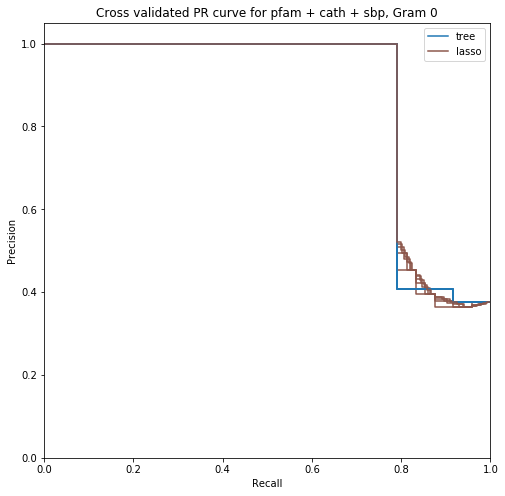

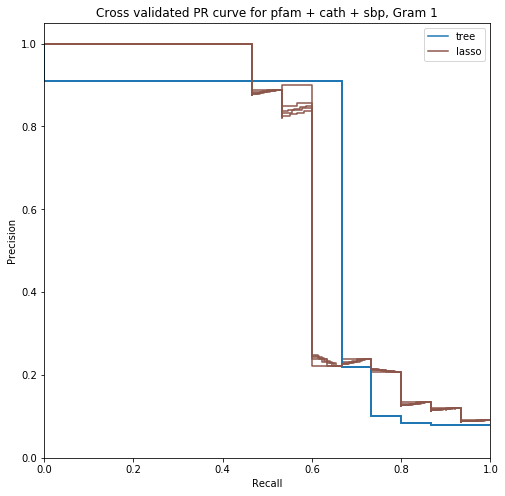

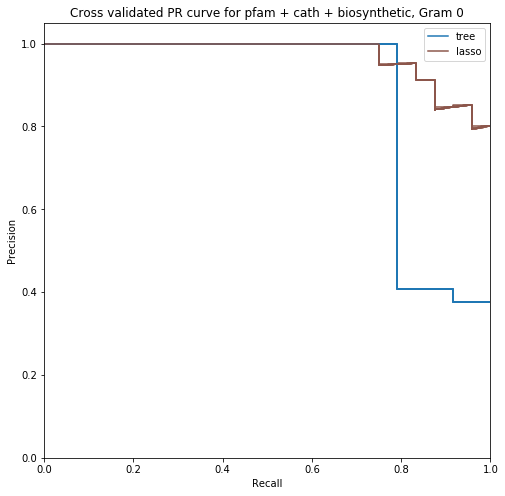

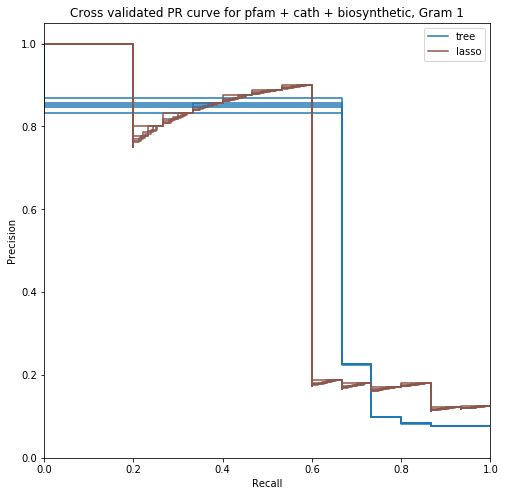

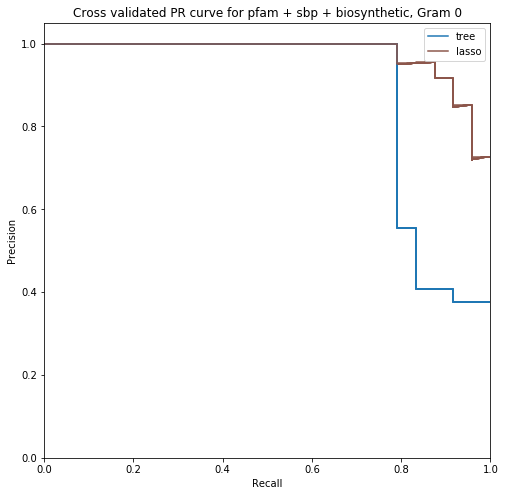

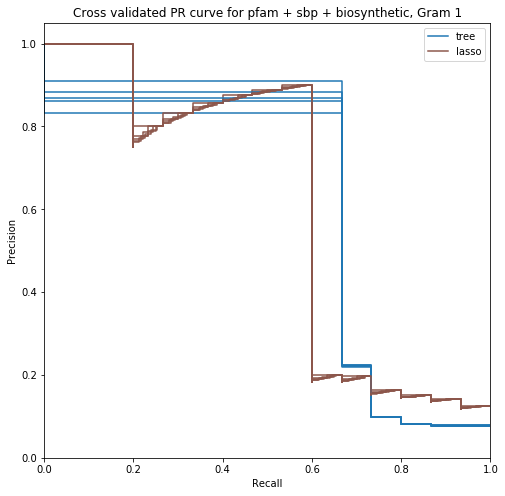

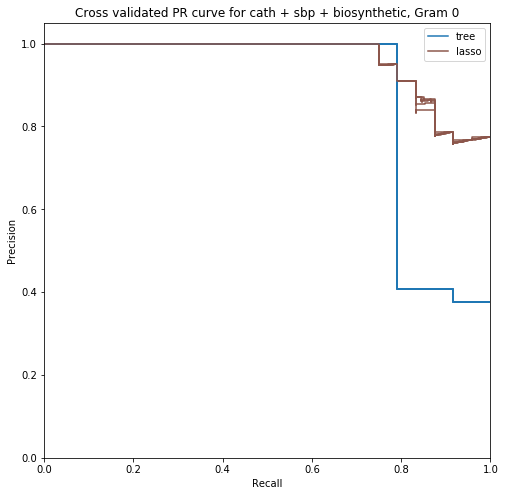

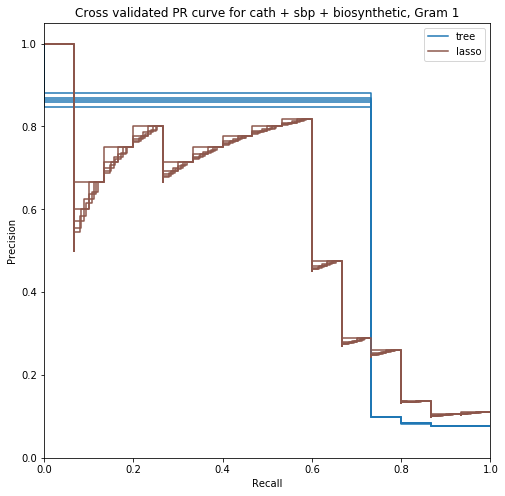

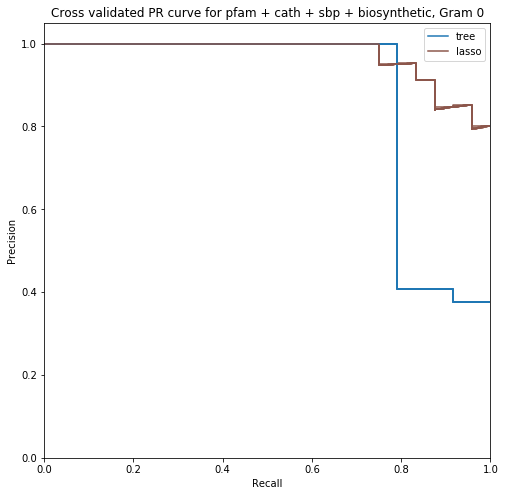

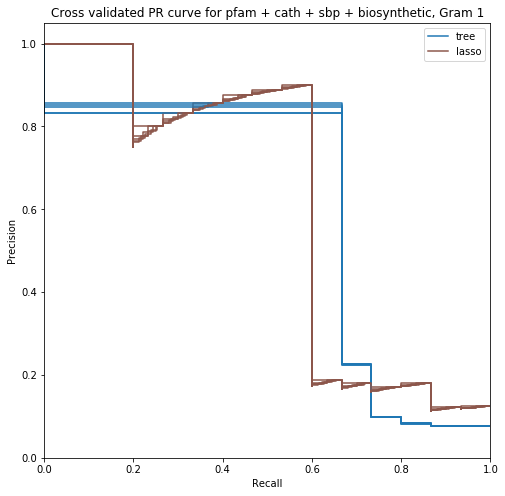

In [8]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

for subset in powerset(siderophore_data.items()):
    if len(subset) == 0:
        continue
    
    # Subset is of the form ((key, data), (key, data), ...)
    # so we have to slice it.
    keys = [x[0] for x in subset] 
    df = [x[1].set_index('BGC') for x in subset]
    df = pd.concat(df, axis=1)

    # Bookkeeping: make BGC a column and remove duplications
    df = df.reset_index()
    df = df.loc[:, ~df.columns.duplicated()]

    names = ' + '.join(keys)
    
    for gram_type, d in df.groupby('Gram'):
        X, y = create_clf_data(d)
        title = f'Cross validated PR curve for {names}, Gram {gram_type}'
        fit_cross_val_and_plot_pr(X, y, classifiers, title=title)
        

Next up, rule stability!

Cross validated rule usage for pfam, Gram 0


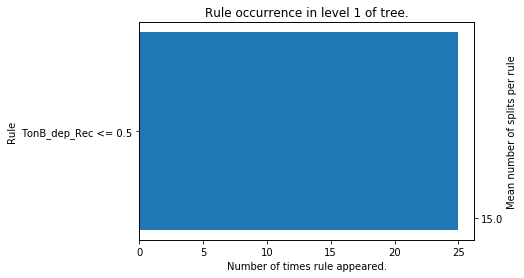

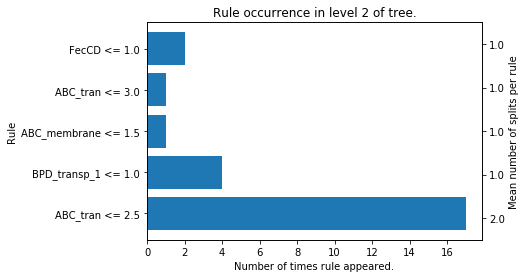

Cross validated rule usage for pfam, Gram 1


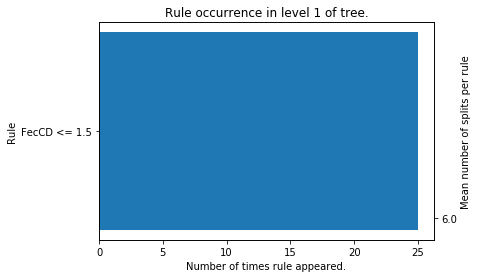

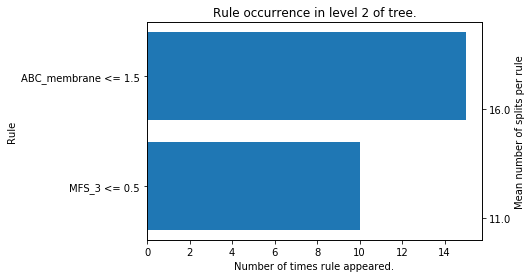

Cross validated rule usage for cath, Gram 0


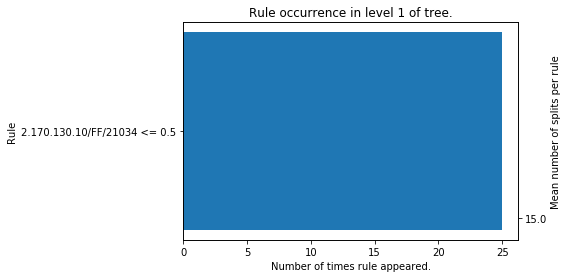

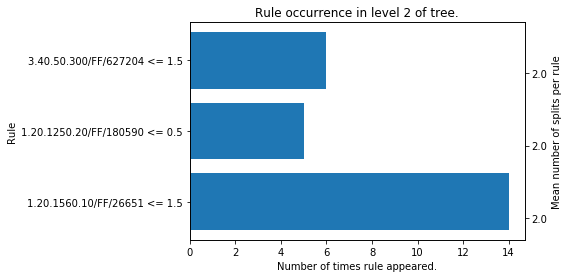

Cross validated rule usage for cath, Gram 1


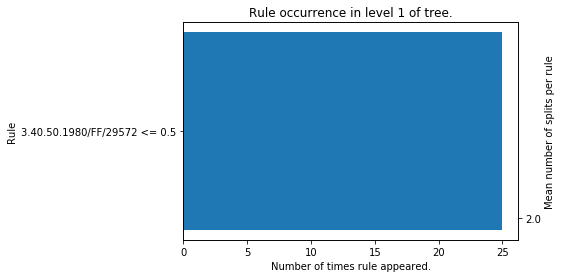

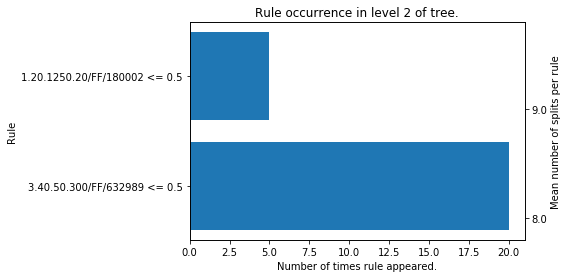

Cross validated rule usage for sbp, Gram 0


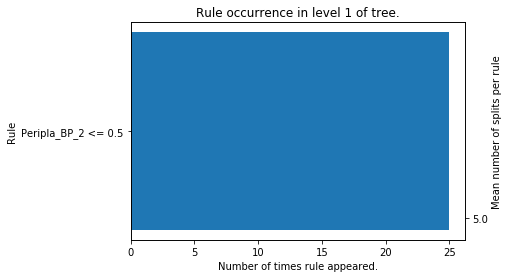

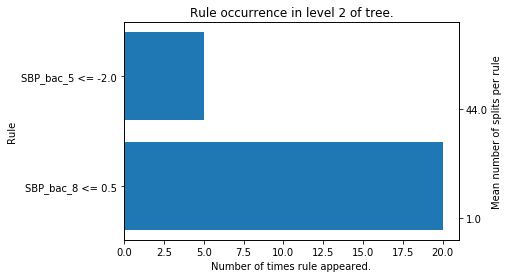

Cross validated rule usage for sbp, Gram 1


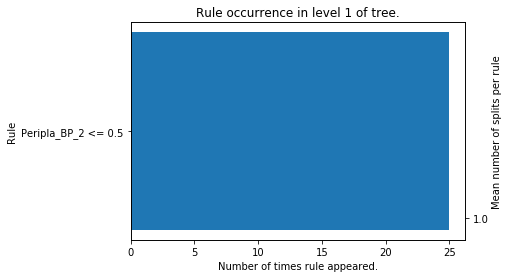

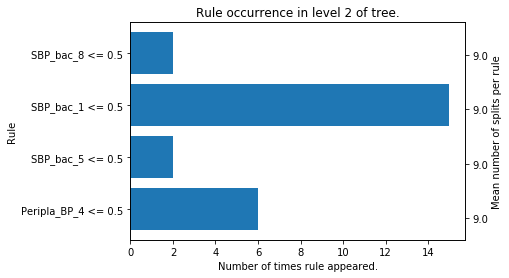

Cross validated rule usage for biosynthetic, Gram 0


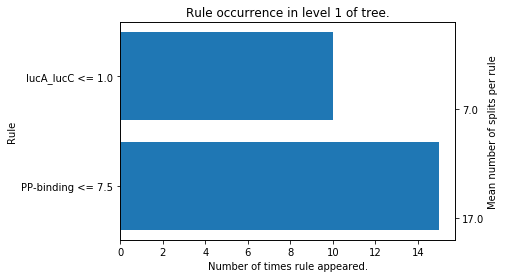

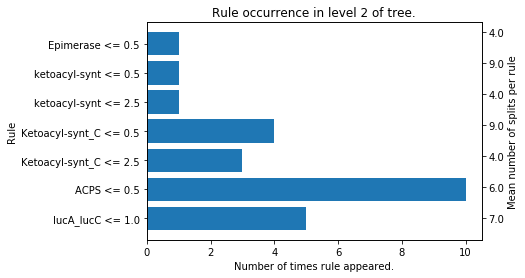

Cross validated rule usage for biosynthetic, Gram 1


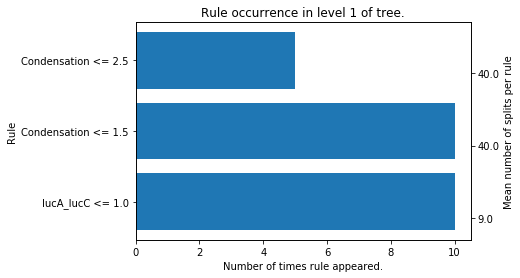

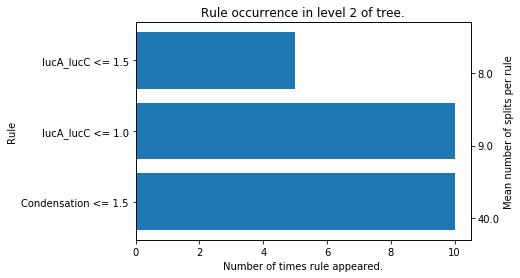

Cross validated rule usage for pfam + cath, Gram 0


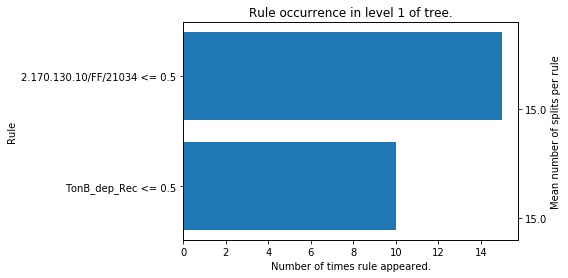

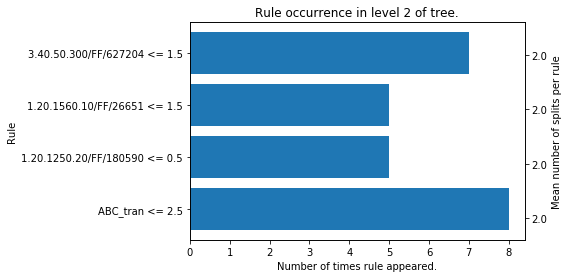

Cross validated rule usage for pfam + cath, Gram 1


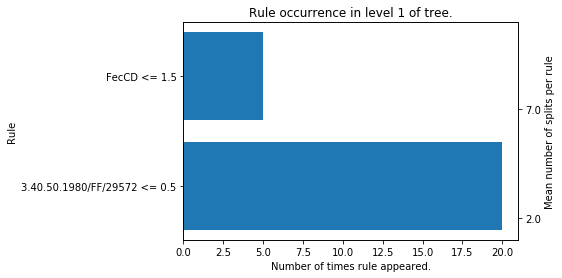

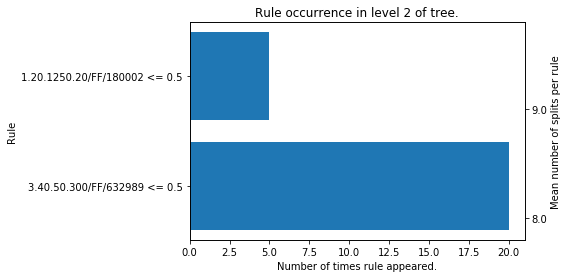

Cross validated rule usage for pfam + sbp, Gram 0


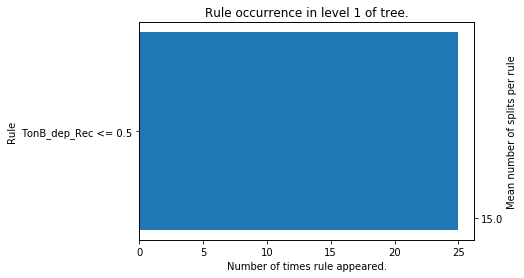

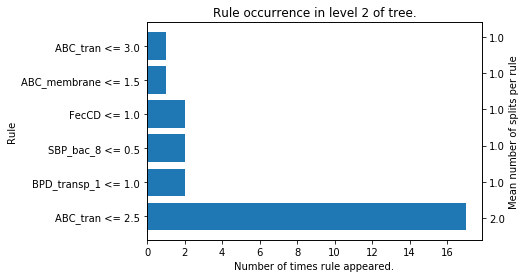

Cross validated rule usage for pfam + sbp, Gram 1


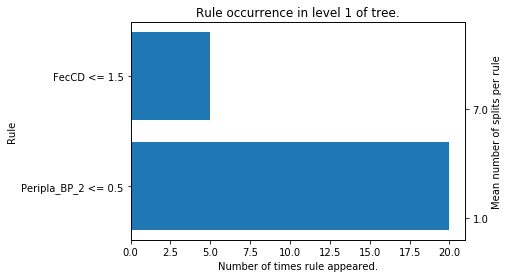

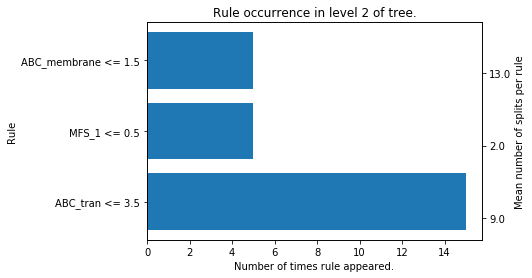

Cross validated rule usage for pfam + biosynthetic, Gram 0


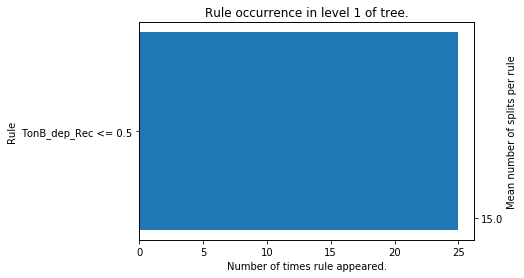

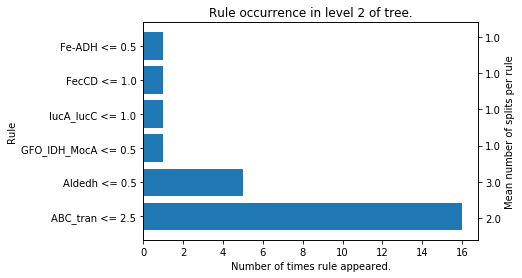

Cross validated rule usage for pfam + biosynthetic, Gram 1


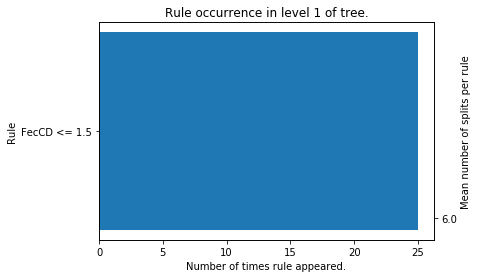

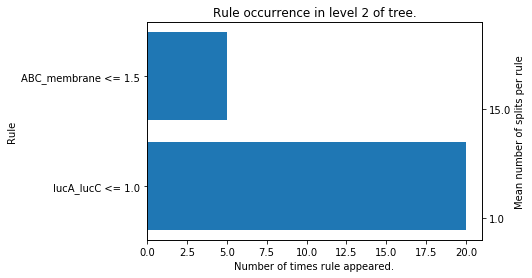

Cross validated rule usage for cath + sbp, Gram 0


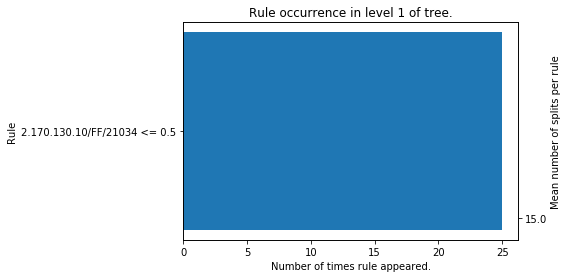

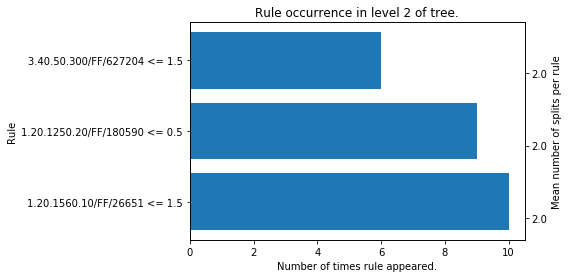

Cross validated rule usage for cath + sbp, Gram 1


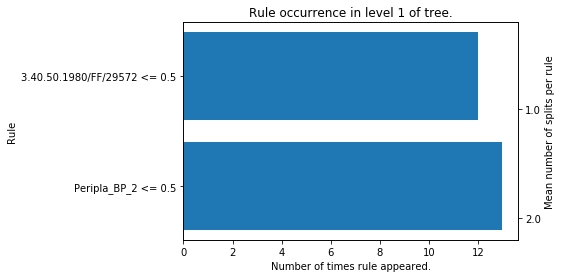

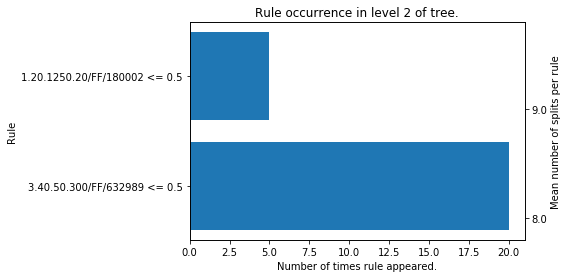

Cross validated rule usage for cath + biosynthetic, Gram 0


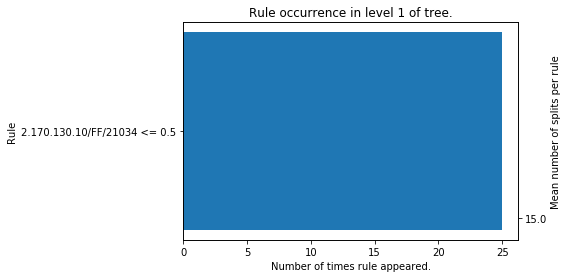

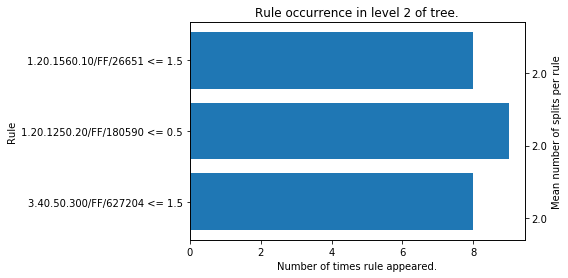

Cross validated rule usage for cath + biosynthetic, Gram 1


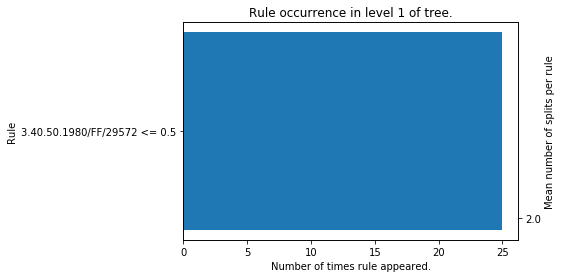

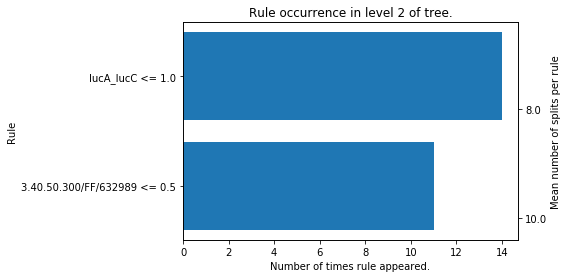

Cross validated rule usage for sbp + biosynthetic, Gram 0


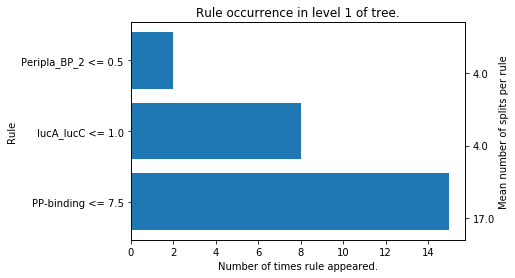

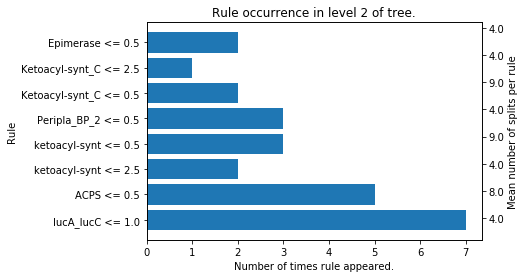

Cross validated rule usage for sbp + biosynthetic, Gram 1


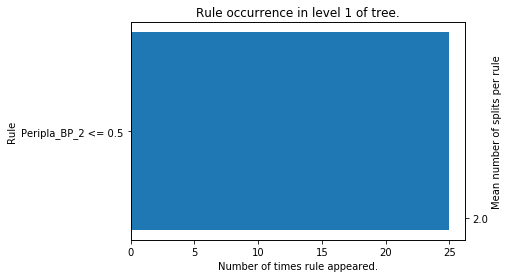

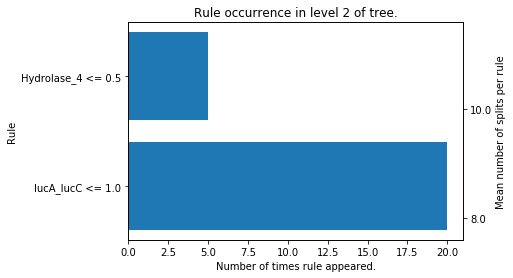

Cross validated rule usage for pfam + cath + sbp, Gram 0


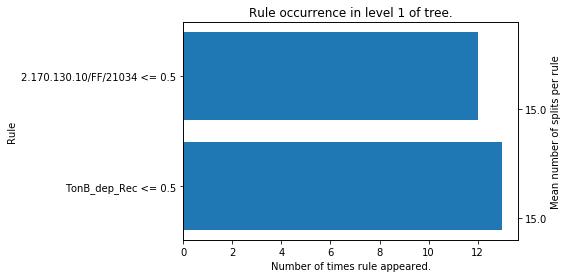

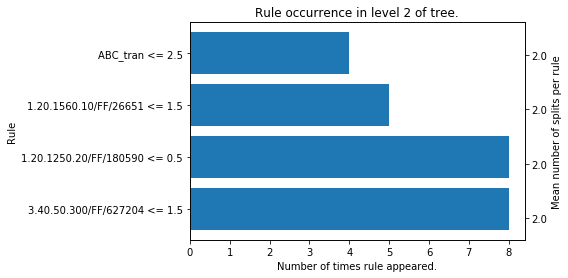

Cross validated rule usage for pfam + cath + sbp, Gram 1


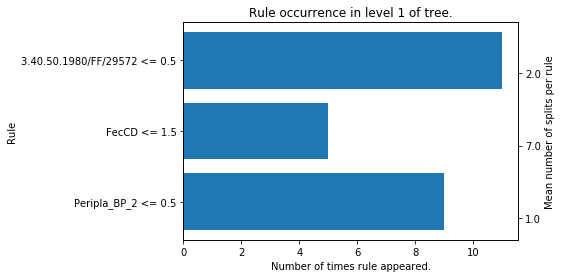

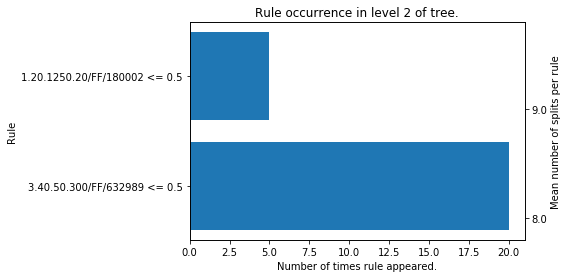

Cross validated rule usage for pfam + cath + biosynthetic, Gram 0


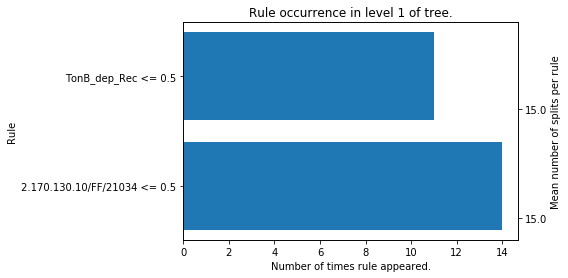

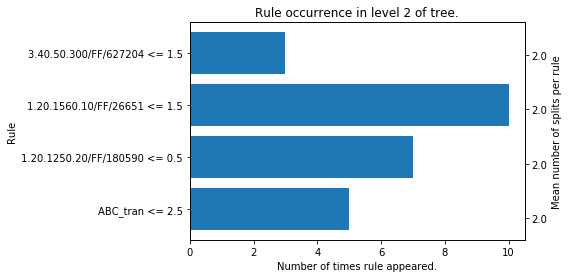

Cross validated rule usage for pfam + cath + biosynthetic, Gram 1


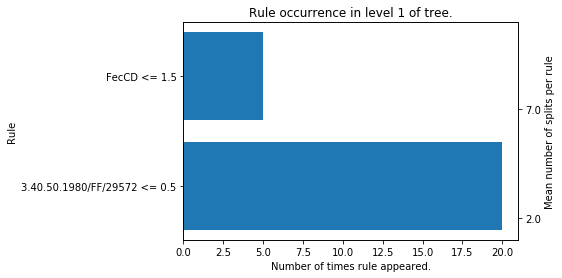

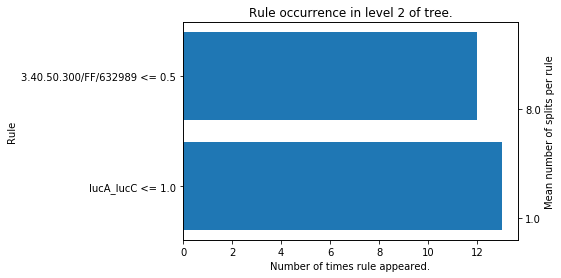

Cross validated rule usage for pfam + sbp + biosynthetic, Gram 0


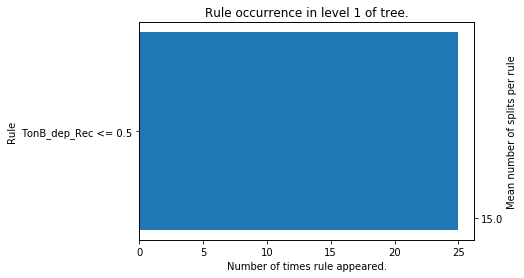

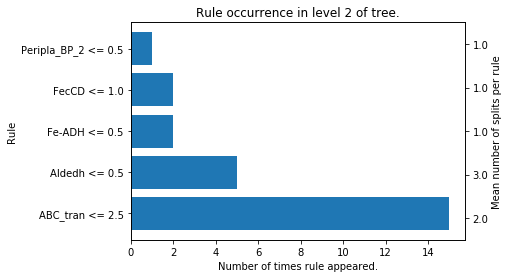

Cross validated rule usage for pfam + sbp + biosynthetic, Gram 1


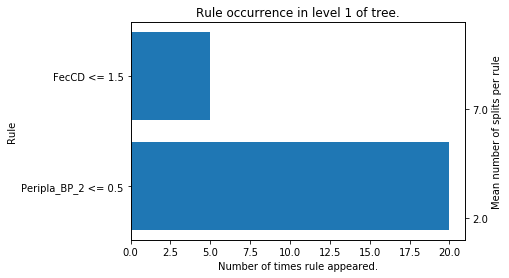

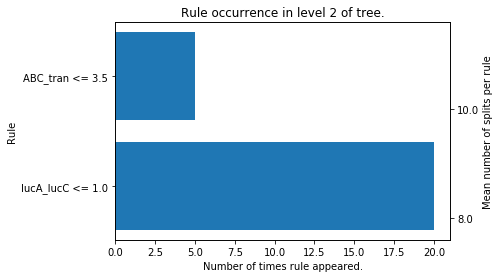

Cross validated rule usage for cath + sbp + biosynthetic, Gram 0


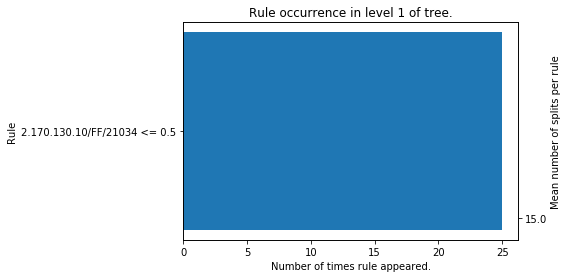

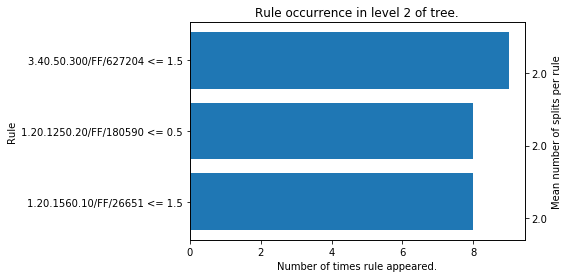

Cross validated rule usage for cath + sbp + biosynthetic, Gram 1


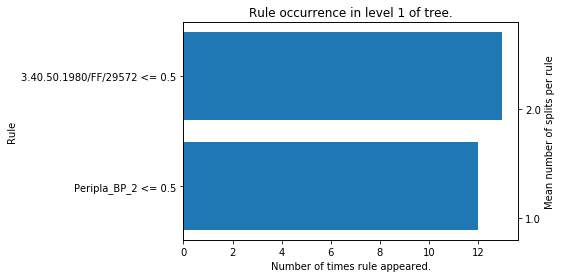

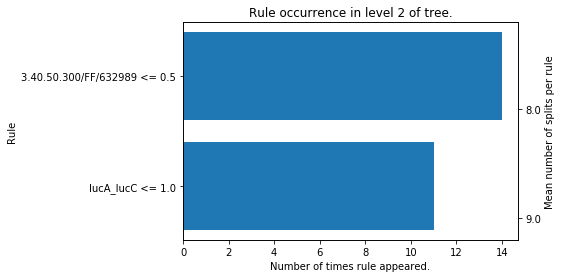

Cross validated rule usage for pfam + cath + sbp + biosynthetic, Gram 0


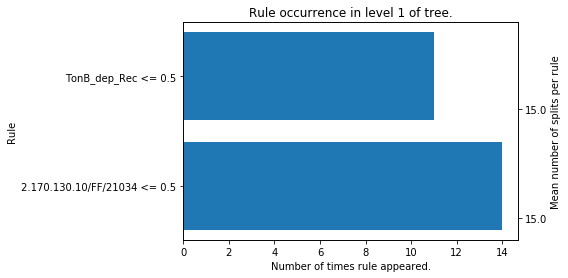

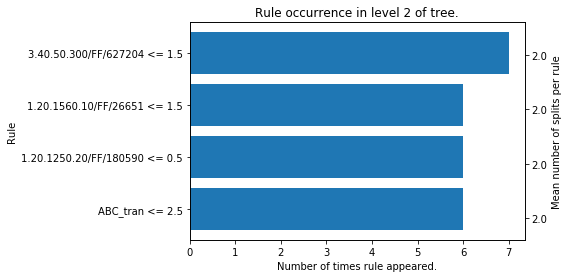

Cross validated rule usage for pfam + cath + sbp + biosynthetic, Gram 1


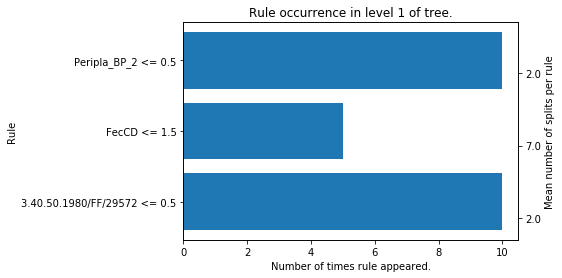

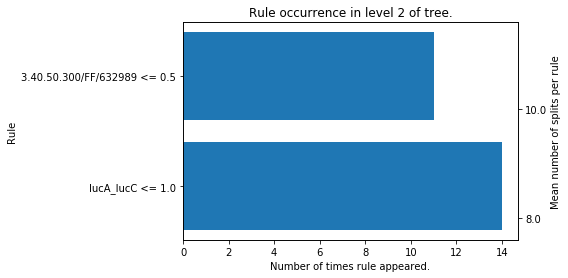

In [9]:
for subset in powerset(siderophore_data.items()):
    if len(subset) == 0:
        continue
    
    # Subset is of the form ((key, data), (key, data), ...)
    # so we have to slice it.
    keys = [x[0] for x in subset] 
    df = [x[1].set_index('BGC') for x in subset]
    df = pd.concat(df, axis=1)

    # Bookkeeping: make BGC a column and remove duplications
    df = df.reset_index()
    df = df.loc[:, ~df.columns.duplicated()]

    names = ' + '.join(keys)
    features = df.columns.drop(['BGC', 'label', 'Gram'])
    
    for gram_type, d in df.groupby('Gram'):
        X, y = create_clf_data(d)
        title = f'Cross validated rule usage for {names}, Gram {gram_type}'
        visualize_tree_rules(X, y, classifiers['tree'], features, title=title)

Lastly, lasso coefficients!

()
(('pfam',             BGC  ABC_tran  BPD_transp_1  TonB_dep_Rec  ABC_membrane  ACR_tran  \
0    BGC0000001         2             2             0             0         0   
2    BGC0000019         2             0             0             0         0   
4    BGC0000026         1             0             0             0         0   
5    BGC0000029         0             0             0             0         0   
8    BGC0000034         1             0             0             0         0   
..          ...       ...           ...           ...           ...       ...   
783  BGC0001861         1             0             0             1         0   
784  BGC0001863         1             0             0             1         0   
787  BGC0001872         1             0             0             0         0   
788  BGC0001877         1             0             0             0         0   
802  BGC0001939         0             0             0             0         0   

     FecCD  AB

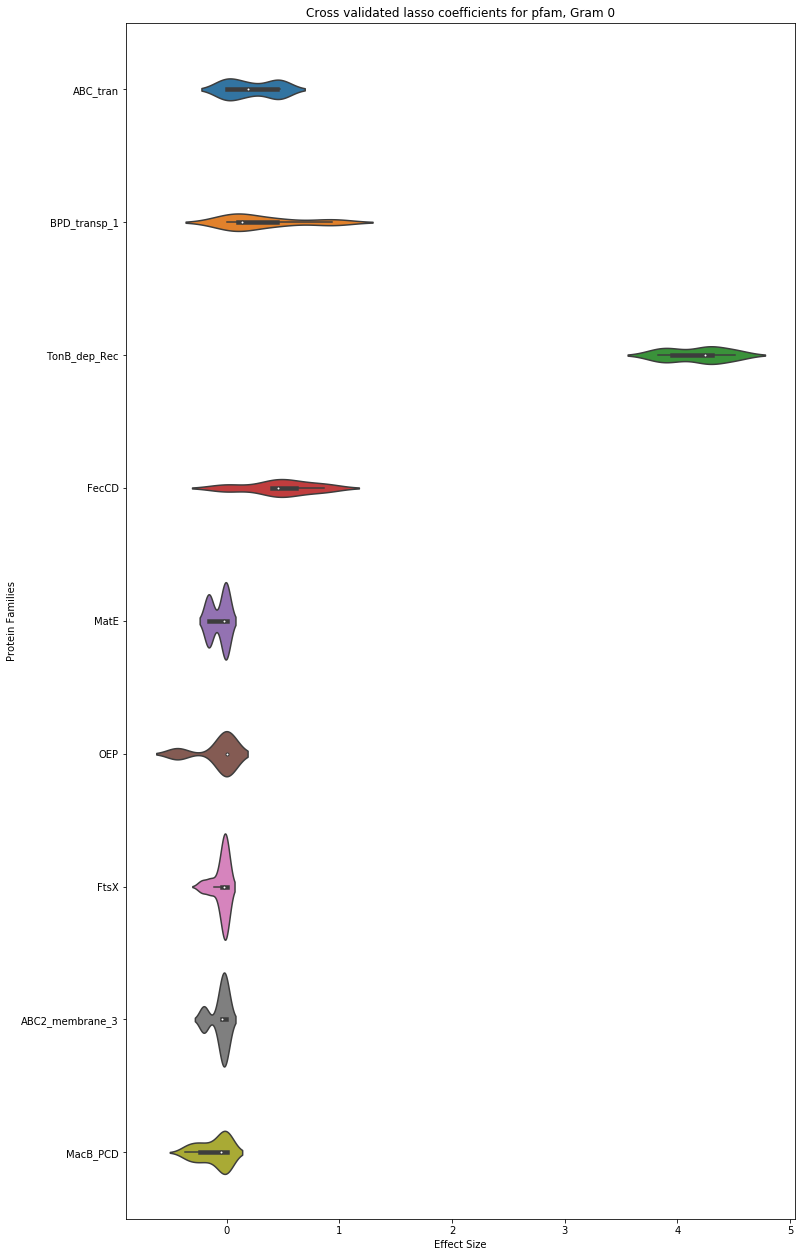

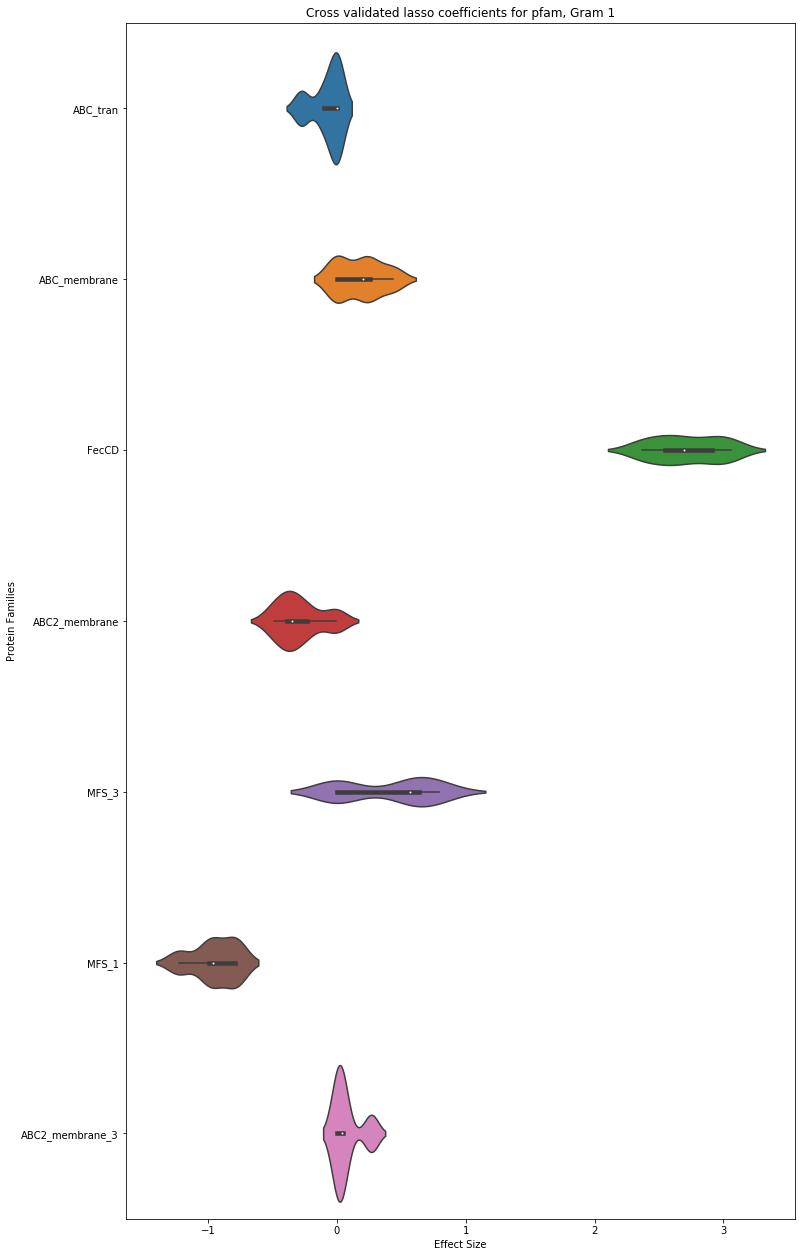

(('cath',             BGC  3.40.50.300/FF/632839  1.10.3470.10/FF/21766  \
0    BGC0000001                      0                      0   
2    BGC0000019                      0                      0   
4    BGC0000026                      0                      0   
5    BGC0000029                      0                      0   
8    BGC0000034                      0                      0   
..          ...                    ...                    ...   
783  BGC0001861                      0                      0   
784  BGC0001863                      0                      0   
787  BGC0001872                      0                      0   
788  BGC0001877                      0                      0   
802  BGC0001939                      0                      0   

     3.40.50.1980/FF/29562  1.20.1640.10/FF/24538  1.20.1250.20/FF/181070  \
0                        0                      0                       0   
2                        0                      0      

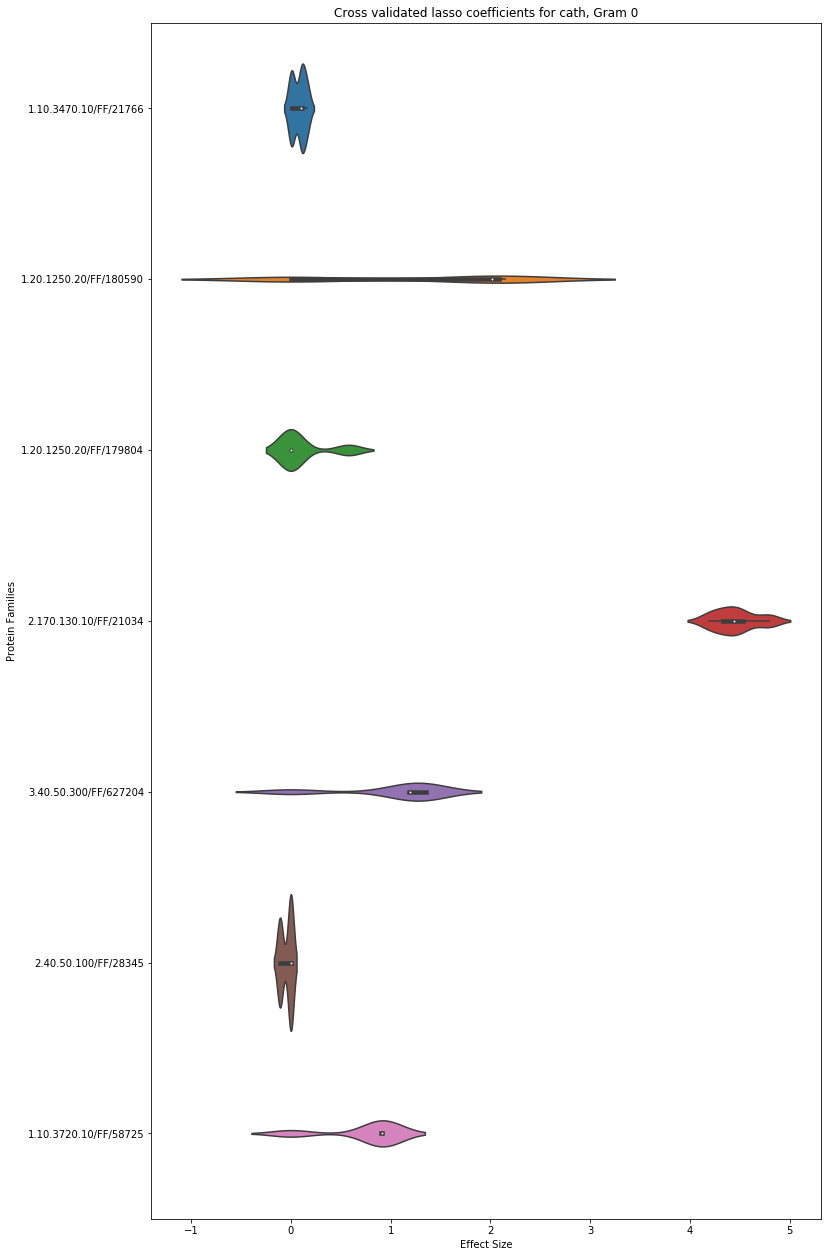

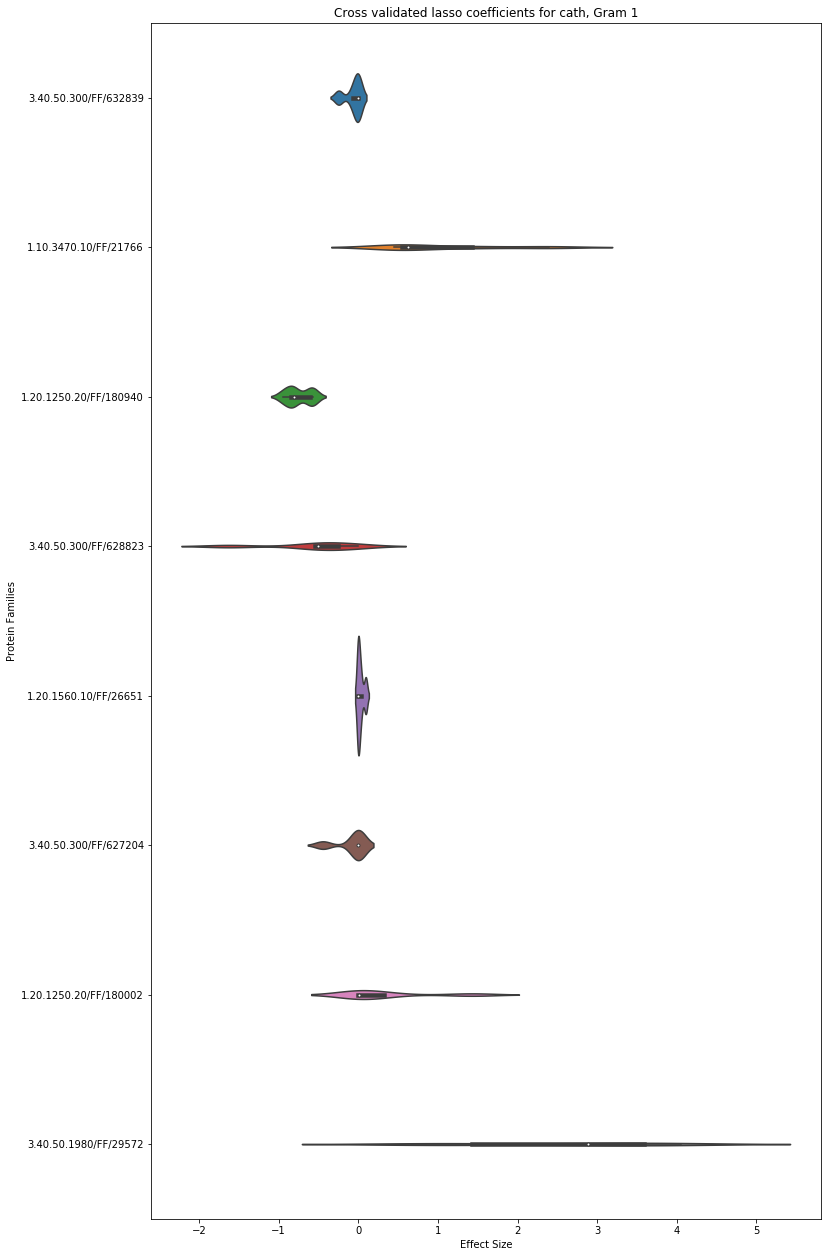

(('sbp',             BGC  PBP_like_2  SBP_bac_3  Peripla_BP_2  SBP_bac_1  SBP_bac_11  \
0    BGC0000001           0          0             0          0           0   
2    BGC0000019           0          0             0          0           0   
4    BGC0000026           0          0             0          0           0   
5    BGC0000029           0          0             0          0           0   
8    BGC0000034           0          0             0          0           0   
..          ...         ...        ...           ...        ...         ...   
783  BGC0001861           0          0             0          0           0   
784  BGC0001863           0          0             0          0           0   
787  BGC0001872           0          0             0          0           0   
788  BGC0001877           0          0             0          0           0   
802  BGC0001939           0          0             0          0           0   

     Peripla_BP_6  Peripla_BP_4  SBP_bac_5

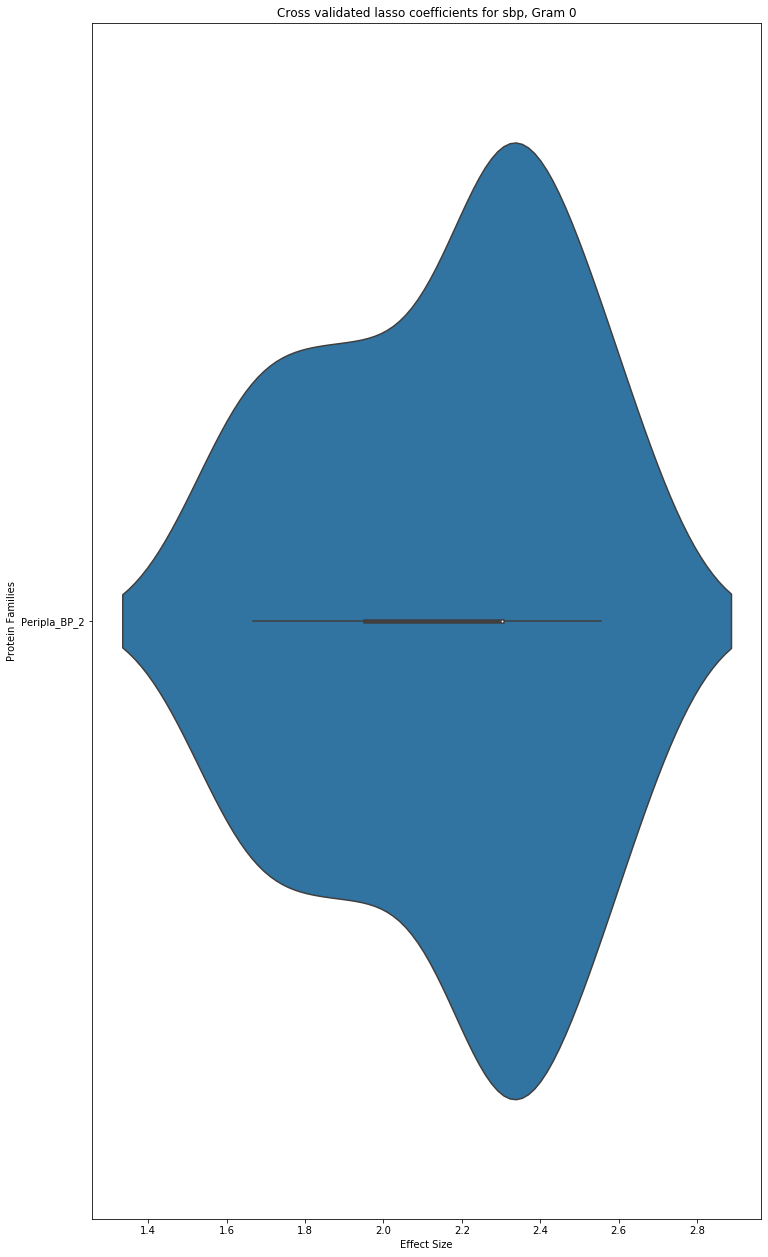

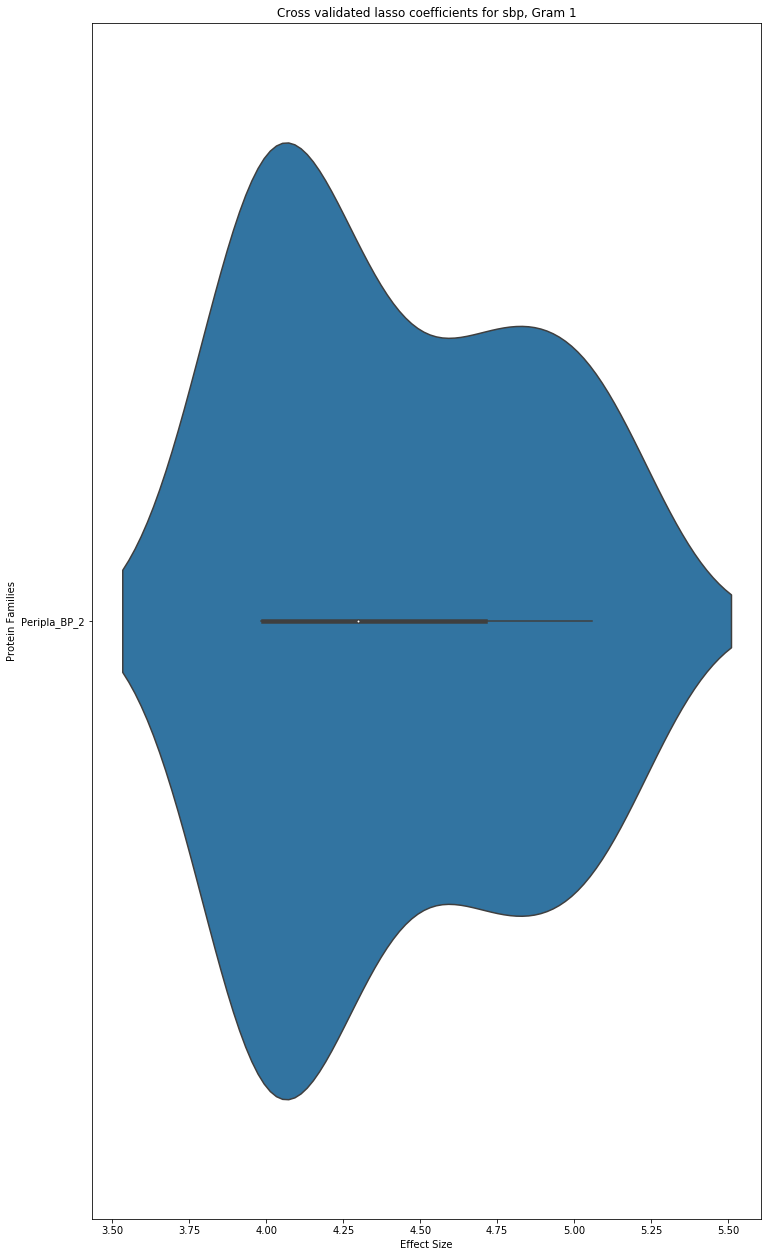

(('biosynthetic',             BGC  2-Hacid_dh  2-Hacid_dh_C  3HCDH  3HCDH_N  4HBT  \
0    BGC0000001           0             0      0        0     0   
2    BGC0000019           0             0      0        0     0   
4    BGC0000026           0             0      0        0     0   
5    BGC0000029           0             0      0        0     0   
8    BGC0000034           0             0      0        0     0   
..          ...         ...           ...    ...      ...   ...   
783  BGC0001861           0             0      0        0     0   
784  BGC0001863           0             0      0        0     0   
787  BGC0001872           0             0      0        0     0   
788  BGC0001877           0             0      0        0     0   
802  BGC0001939           0             0      0        0     0   

     Abhydrolase_1  Abhydrolase_3  Acetyltransf_1  ACPS  ...  Thiolase_N  \
0                0              0               0     0  ...           0   
2                0       

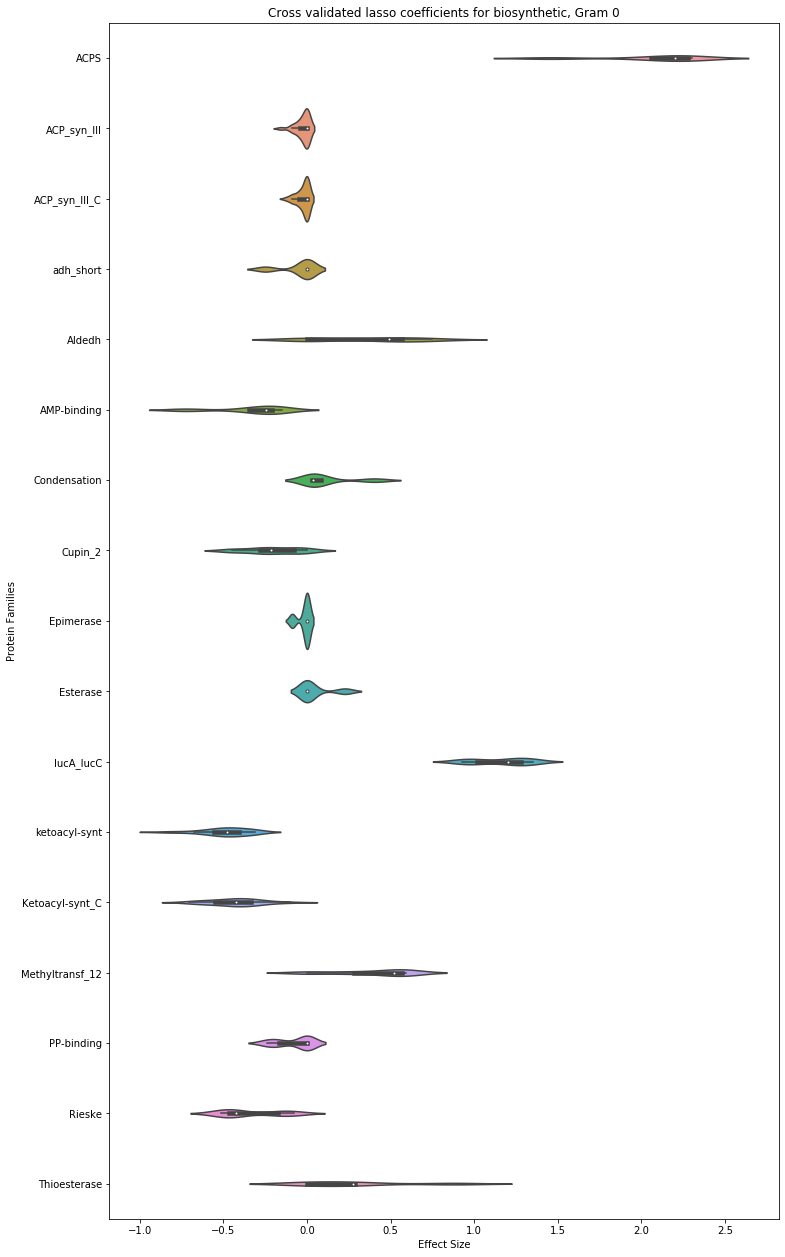

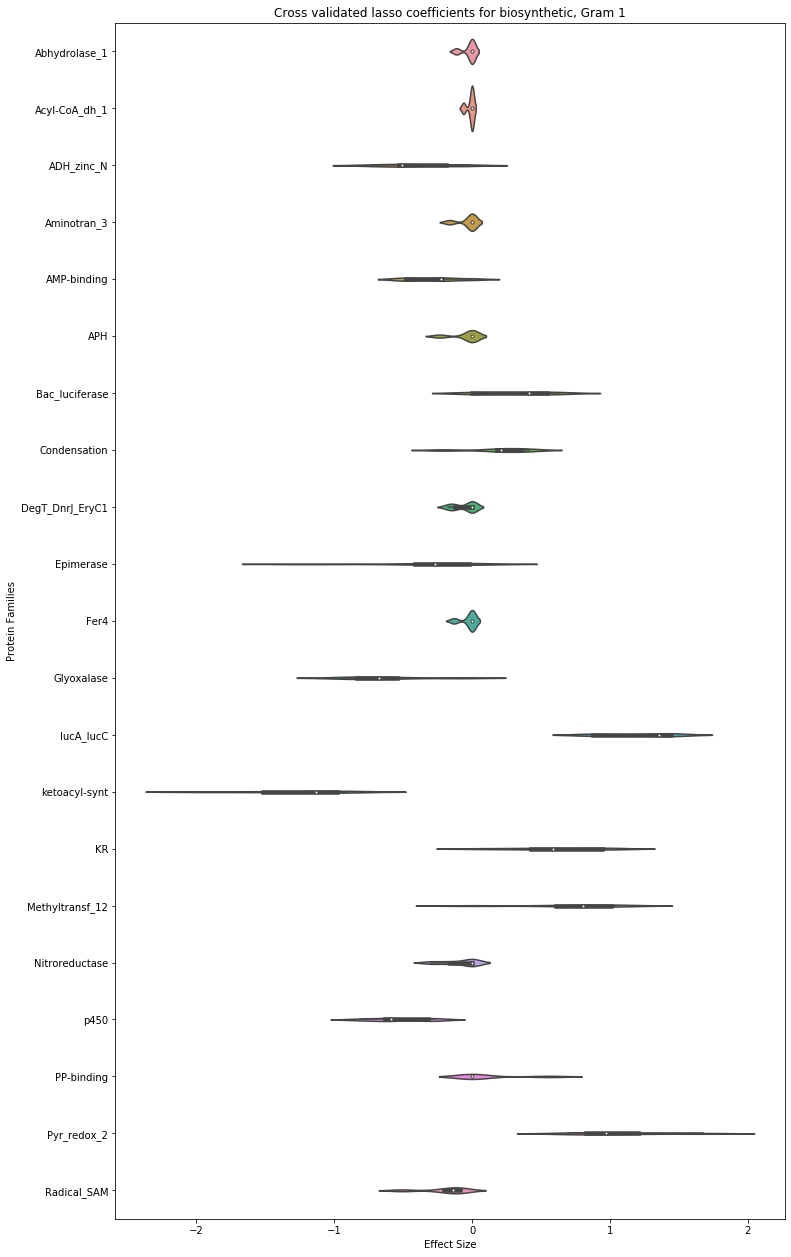

(('pfam',             BGC  ABC_tran  BPD_transp_1  TonB_dep_Rec  ABC_membrane  ACR_tran  \
0    BGC0000001         2             2             0             0         0   
2    BGC0000019         2             0             0             0         0   
4    BGC0000026         1             0             0             0         0   
5    BGC0000029         0             0             0             0         0   
8    BGC0000034         1             0             0             0         0   
..          ...       ...           ...           ...           ...       ...   
783  BGC0001861         1             0             0             1         0   
784  BGC0001863         1             0             0             1         0   
787  BGC0001872         1             0             0             0         0   
788  BGC0001877         1             0             0             0         0   
802  BGC0001939         0             0             0             0         0   

     FecCD  ABC2_

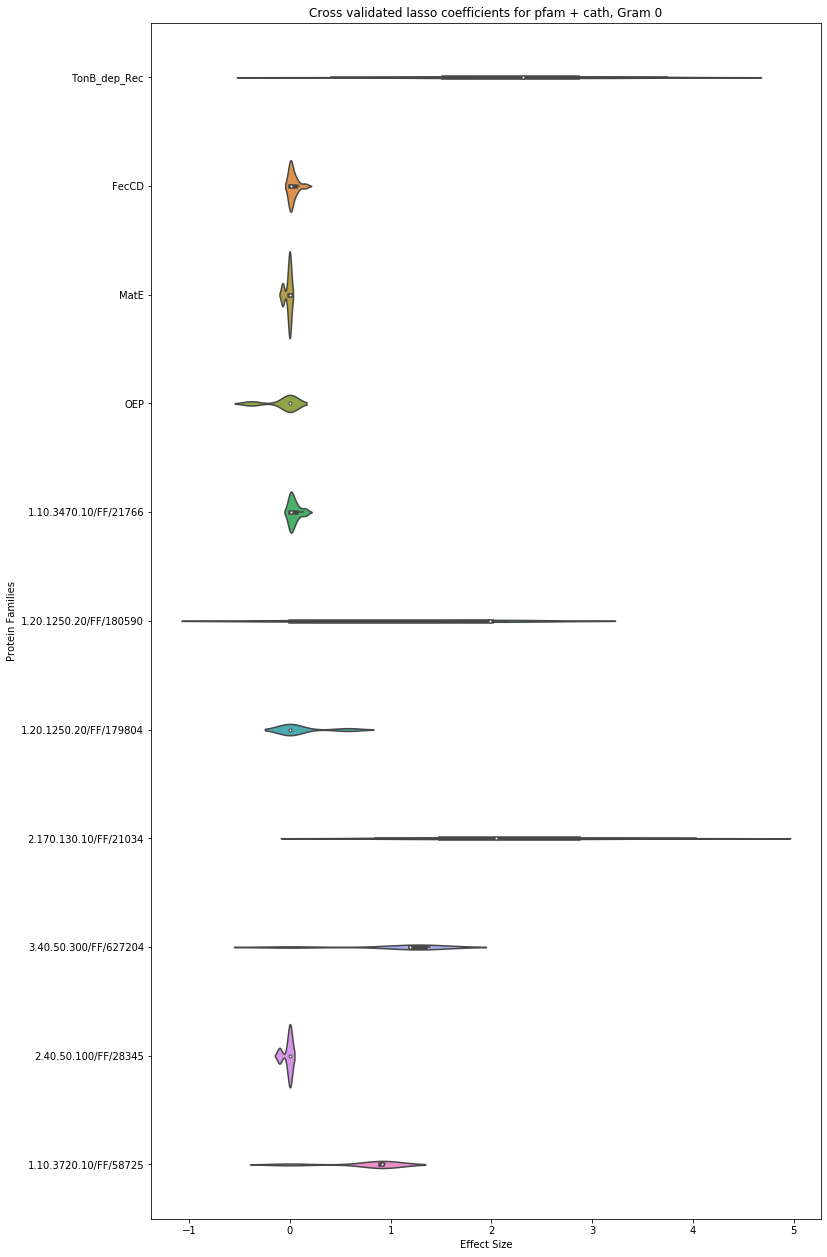

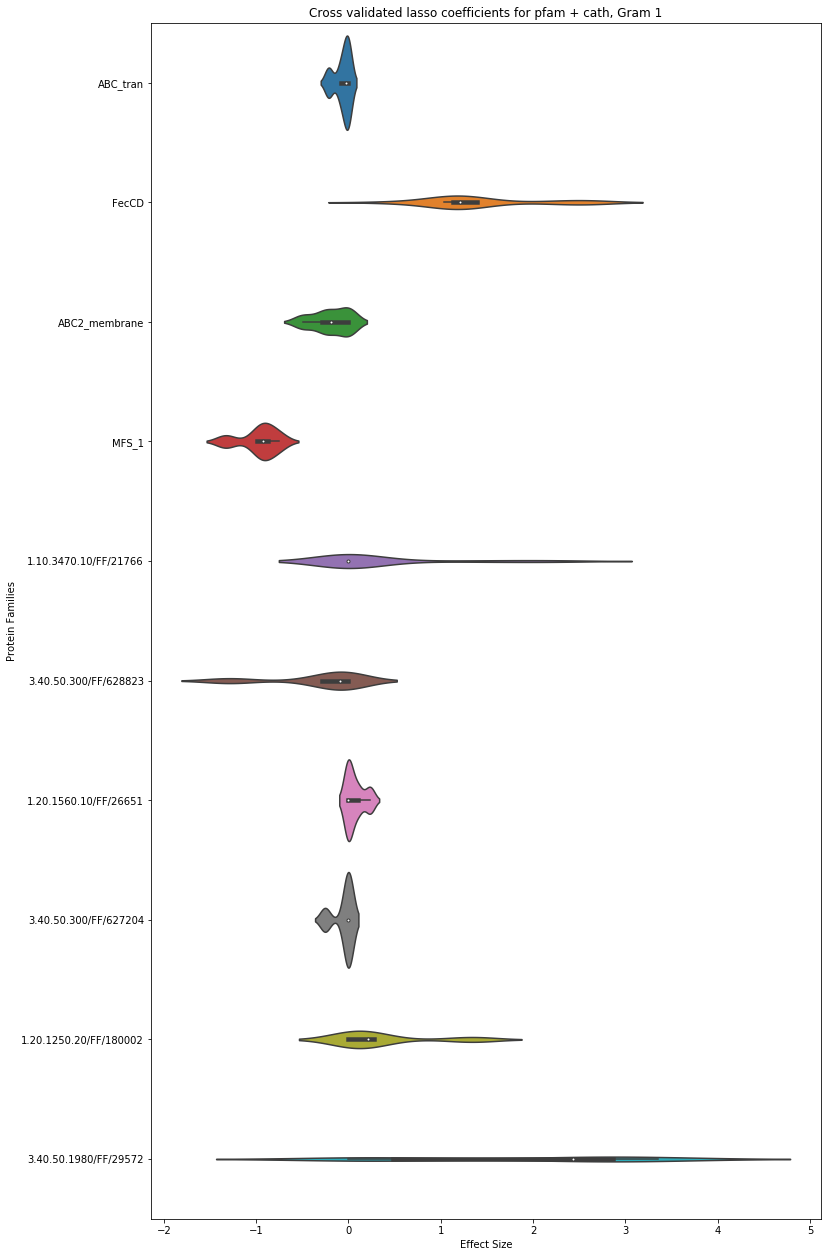

(('pfam',             BGC  ABC_tran  BPD_transp_1  TonB_dep_Rec  ABC_membrane  ACR_tran  \
0    BGC0000001         2             2             0             0         0   
2    BGC0000019         2             0             0             0         0   
4    BGC0000026         1             0             0             0         0   
5    BGC0000029         0             0             0             0         0   
8    BGC0000034         1             0             0             0         0   
..          ...       ...           ...           ...           ...       ...   
783  BGC0001861         1             0             0             1         0   
784  BGC0001863         1             0             0             1         0   
787  BGC0001872         1             0             0             0         0   
788  BGC0001877         1             0             0             0         0   
802  BGC0001939         0             0             0             0         0   

     FecCD  ABC2_

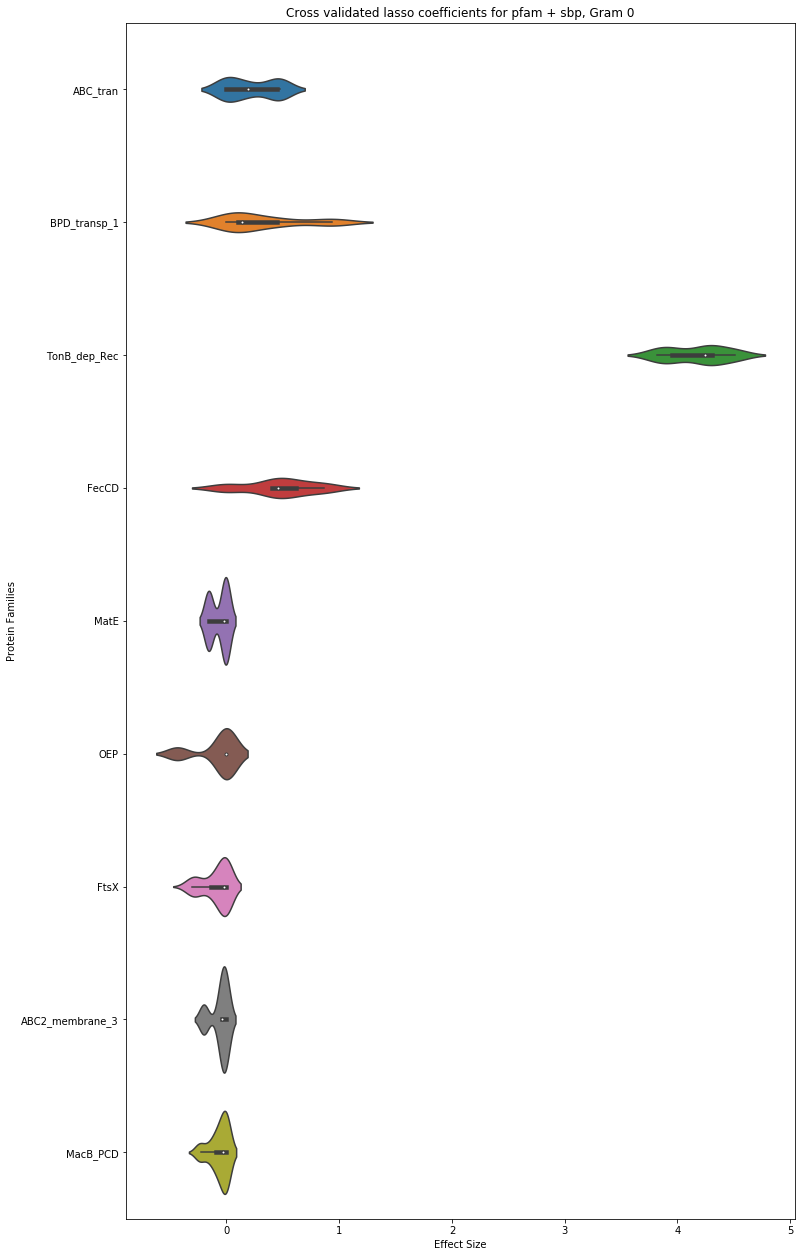

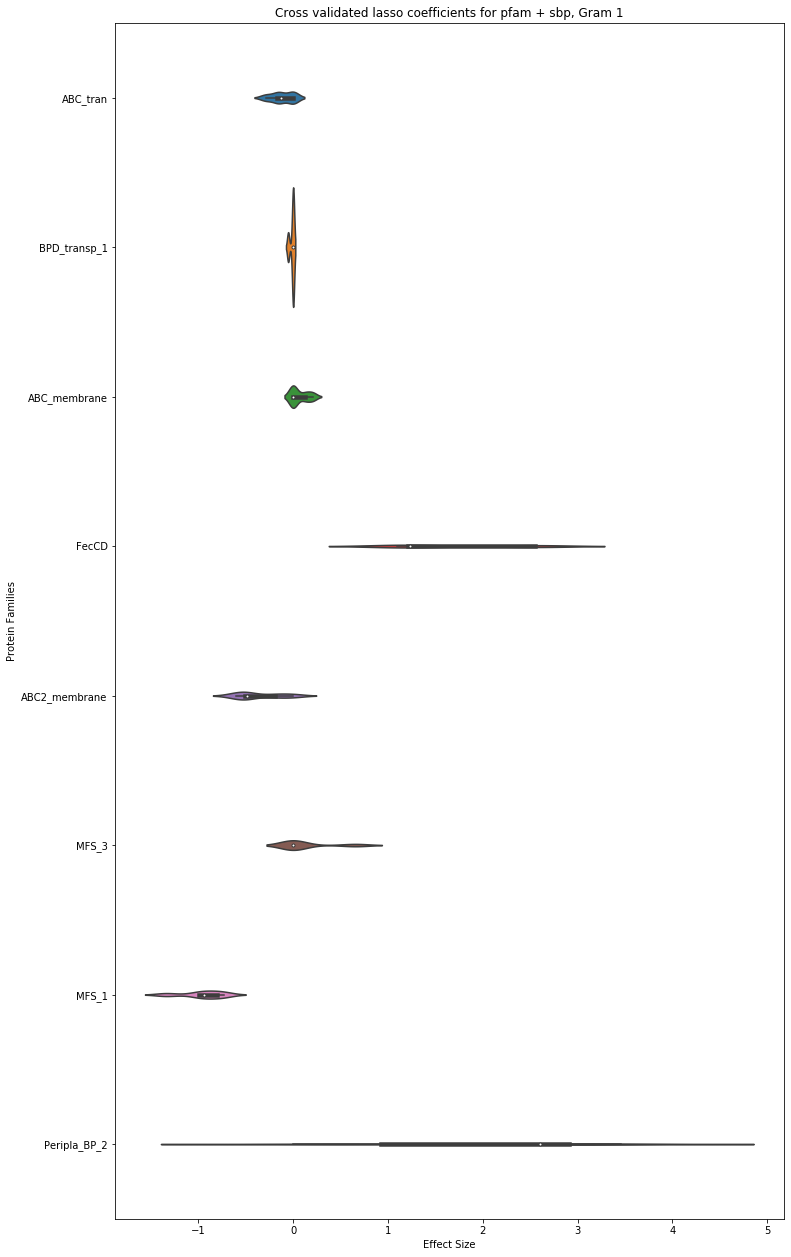

(('pfam',             BGC  ABC_tran  BPD_transp_1  TonB_dep_Rec  ABC_membrane  ACR_tran  \
0    BGC0000001         2             2             0             0         0   
2    BGC0000019         2             0             0             0         0   
4    BGC0000026         1             0             0             0         0   
5    BGC0000029         0             0             0             0         0   
8    BGC0000034         1             0             0             0         0   
..          ...       ...           ...           ...           ...       ...   
783  BGC0001861         1             0             0             1         0   
784  BGC0001863         1             0             0             1         0   
787  BGC0001872         1             0             0             0         0   
788  BGC0001877         1             0             0             0         0   
802  BGC0001939         0             0             0             0         0   

     FecCD  ABC2_

/home/metta/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


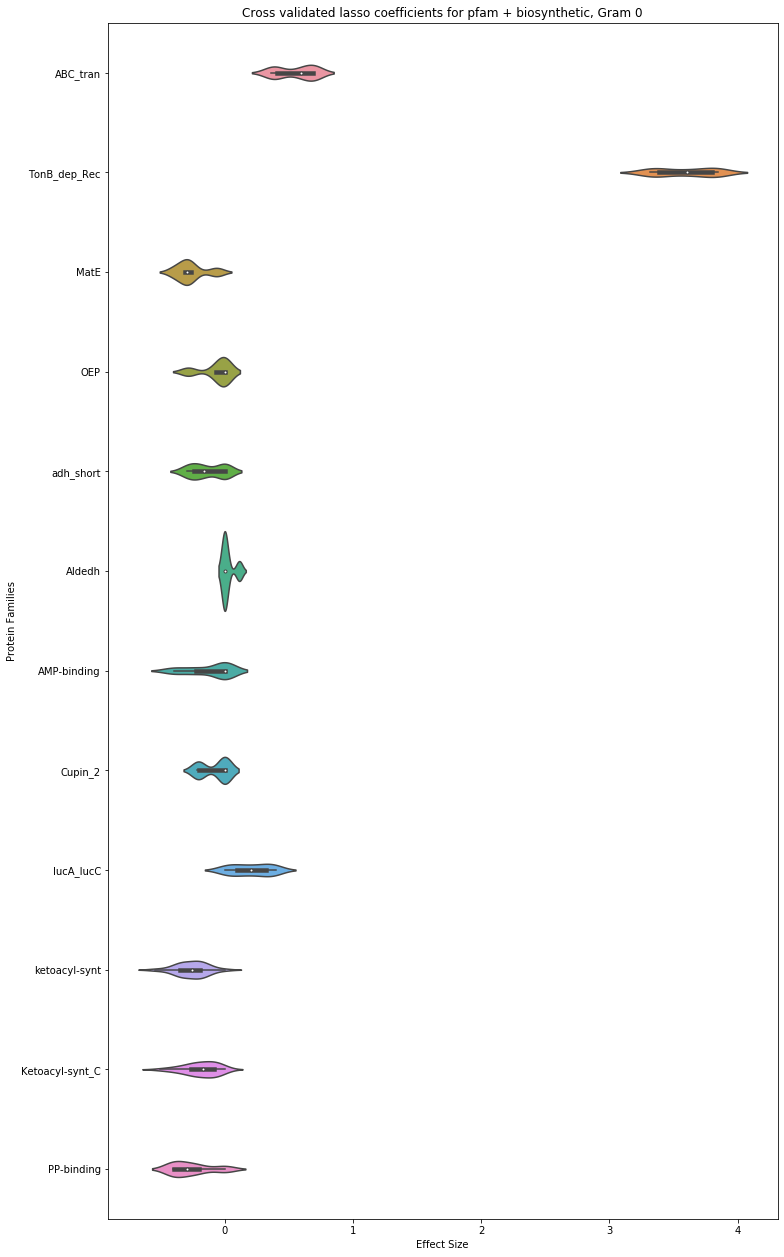

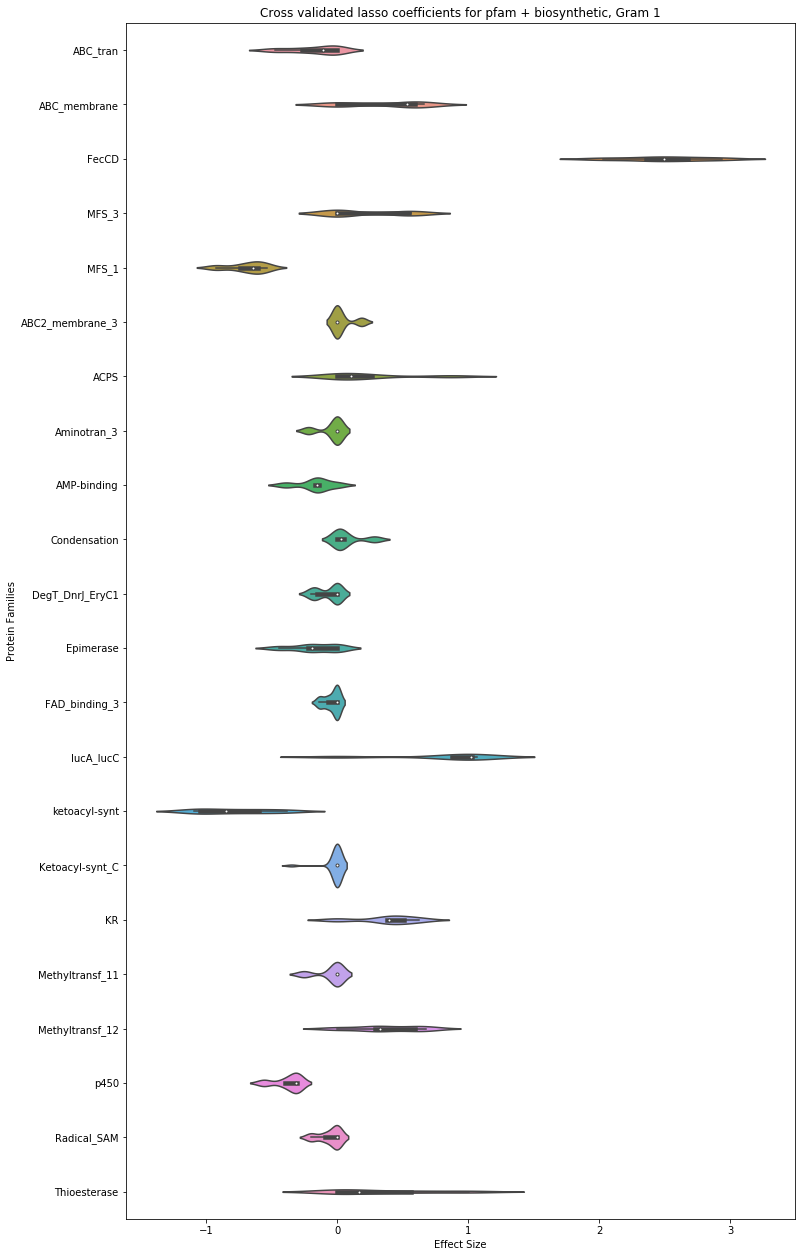

(('cath',             BGC  3.40.50.300/FF/632839  1.10.3470.10/FF/21766  \
0    BGC0000001                      0                      0   
2    BGC0000019                      0                      0   
4    BGC0000026                      0                      0   
5    BGC0000029                      0                      0   
8    BGC0000034                      0                      0   
..          ...                    ...                    ...   
783  BGC0001861                      0                      0   
784  BGC0001863                      0                      0   
787  BGC0001872                      0                      0   
788  BGC0001877                      0                      0   
802  BGC0001939                      0                      0   

     3.40.50.1980/FF/29562  1.20.1640.10/FF/24538  1.20.1250.20/FF/181070  \
0                        0                      0                       0   
2                        0                      0      

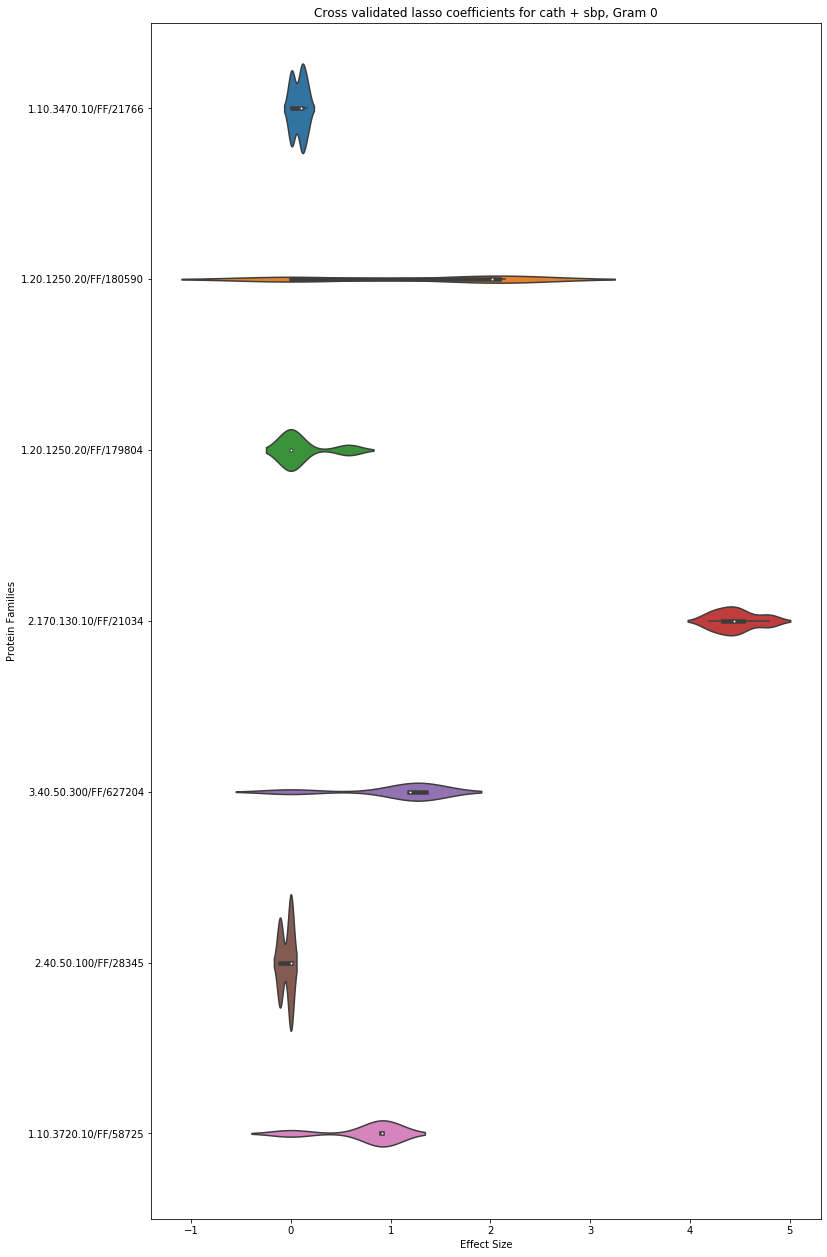

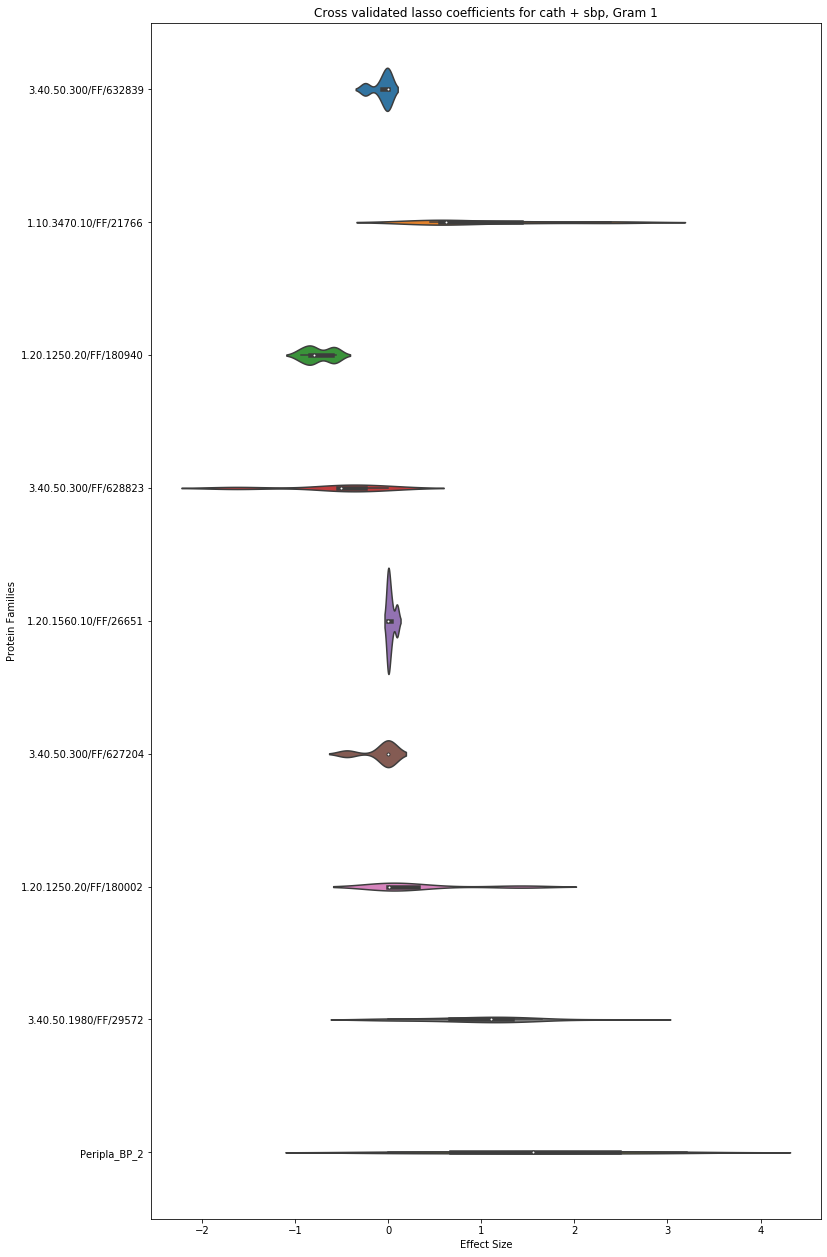

(('cath',             BGC  3.40.50.300/FF/632839  1.10.3470.10/FF/21766  \
0    BGC0000001                      0                      0   
2    BGC0000019                      0                      0   
4    BGC0000026                      0                      0   
5    BGC0000029                      0                      0   
8    BGC0000034                      0                      0   
..          ...                    ...                    ...   
783  BGC0001861                      0                      0   
784  BGC0001863                      0                      0   
787  BGC0001872                      0                      0   
788  BGC0001877                      0                      0   
802  BGC0001939                      0                      0   

     3.40.50.1980/FF/29562  1.20.1640.10/FF/24538  1.20.1250.20/FF/181070  \
0                        0                      0                       0   
2                        0                      0      

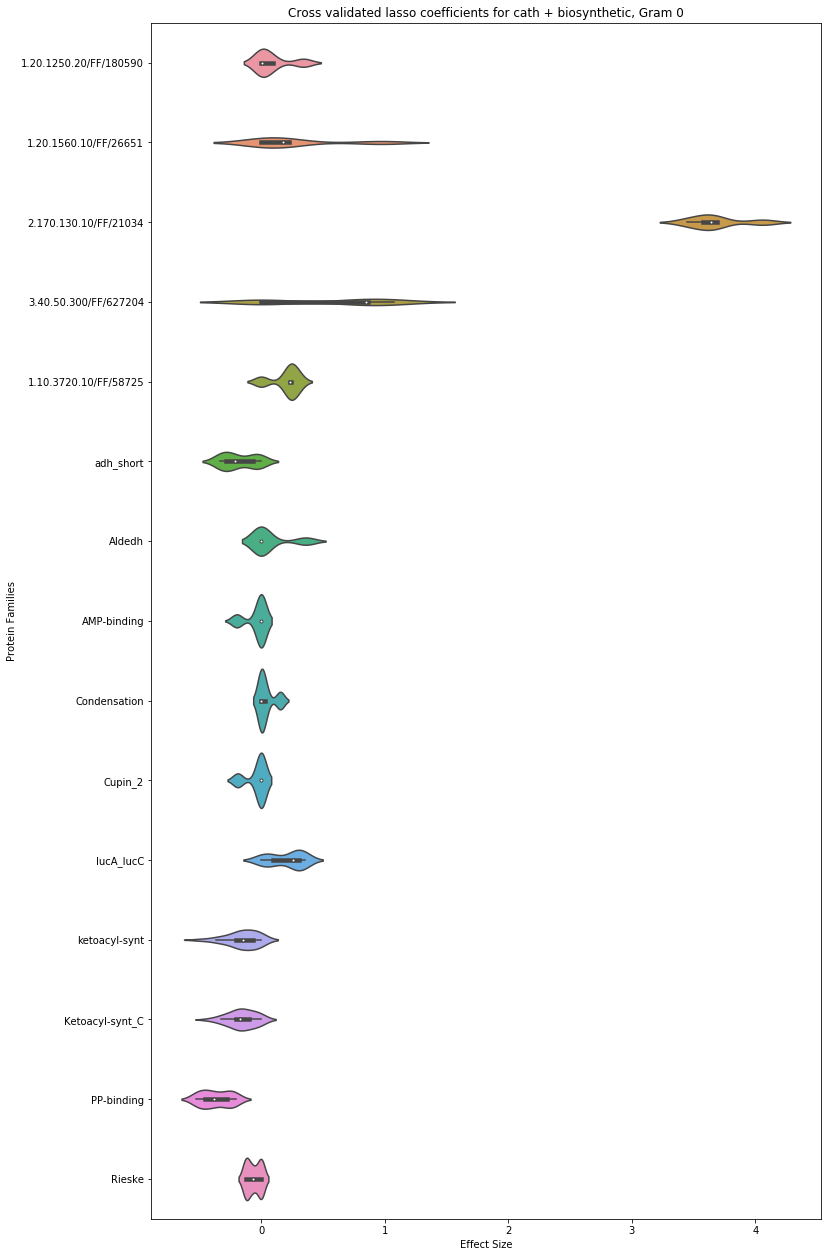

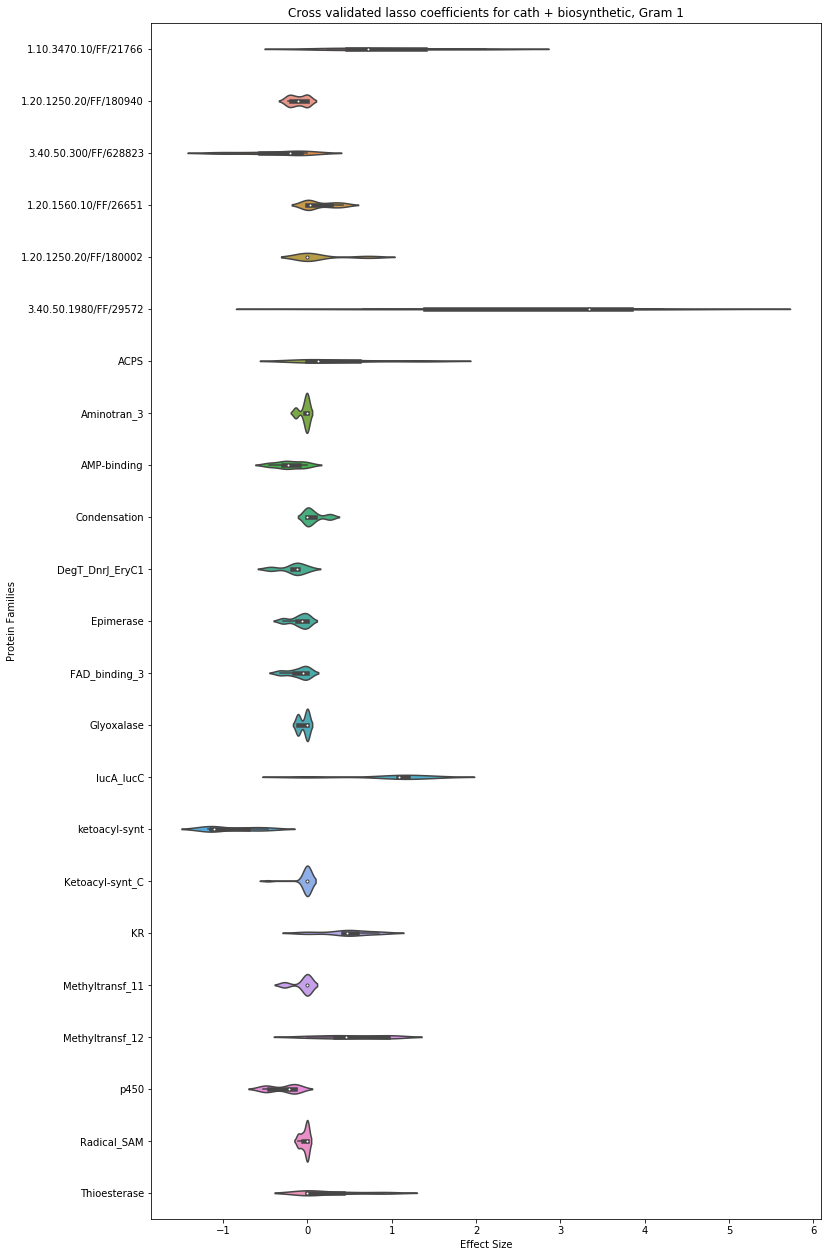

(('sbp',             BGC  PBP_like_2  SBP_bac_3  Peripla_BP_2  SBP_bac_1  SBP_bac_11  \
0    BGC0000001           0          0             0          0           0   
2    BGC0000019           0          0             0          0           0   
4    BGC0000026           0          0             0          0           0   
5    BGC0000029           0          0             0          0           0   
8    BGC0000034           0          0             0          0           0   
..          ...         ...        ...           ...        ...         ...   
783  BGC0001861           0          0             0          0           0   
784  BGC0001863           0          0             0          0           0   
787  BGC0001872           0          0             0          0           0   
788  BGC0001877           0          0             0          0           0   
802  BGC0001939           0          0             0          0           0   

     Peripla_BP_6  Peripla_BP_4  SBP_bac_5

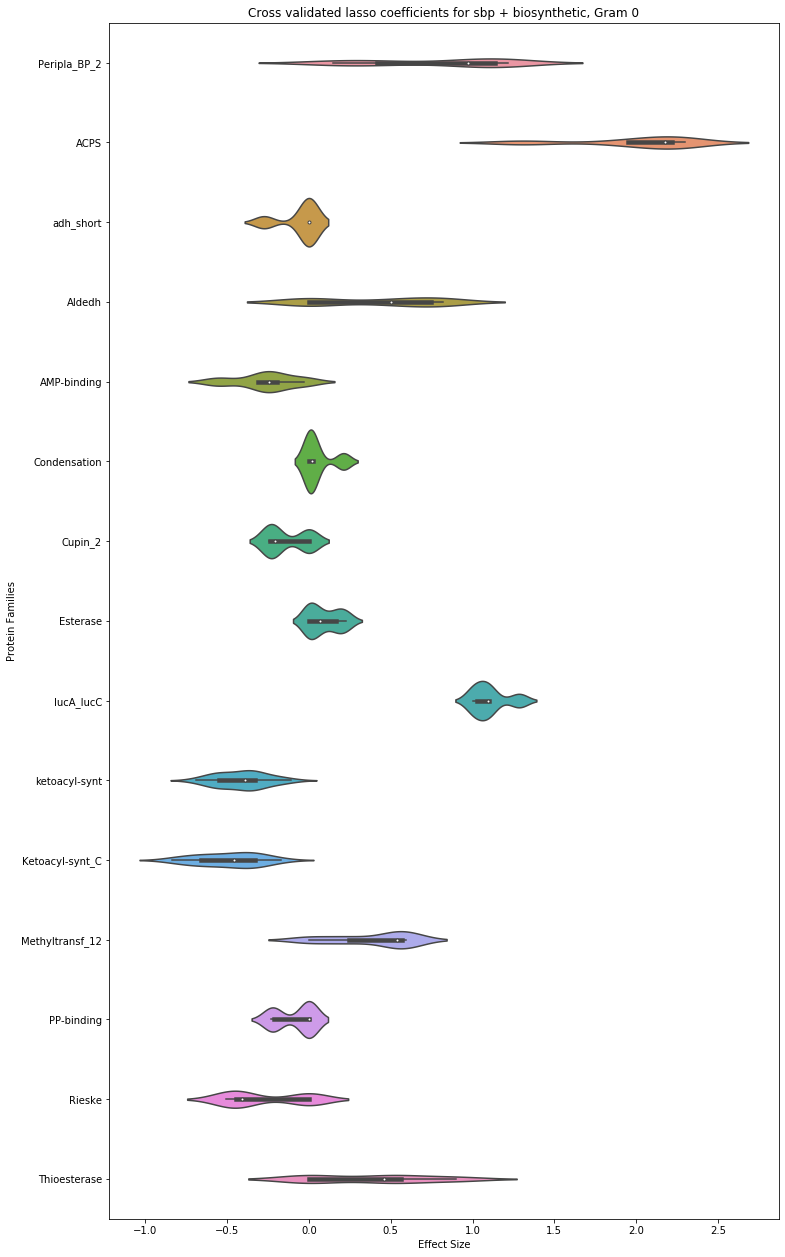

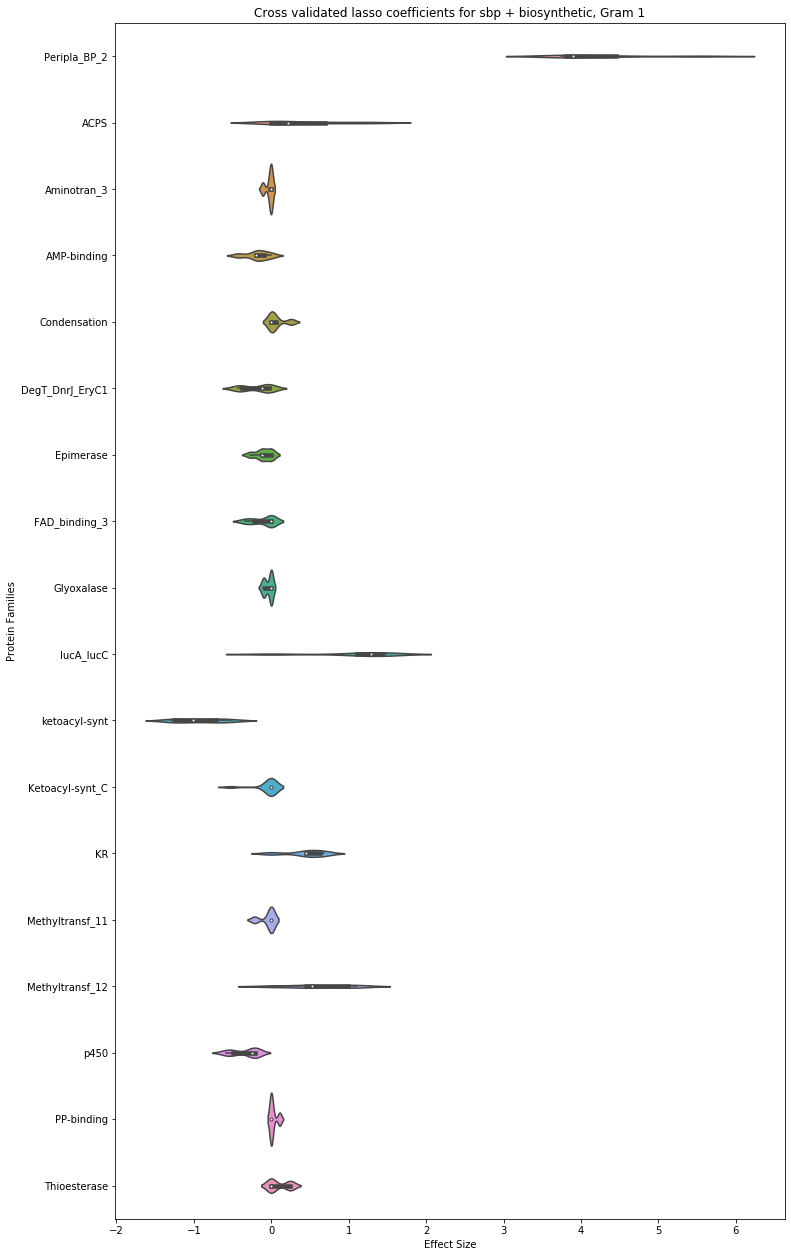

(('pfam',             BGC  ABC_tran  BPD_transp_1  TonB_dep_Rec  ABC_membrane  ACR_tran  \
0    BGC0000001         2             2             0             0         0   
2    BGC0000019         2             0             0             0         0   
4    BGC0000026         1             0             0             0         0   
5    BGC0000029         0             0             0             0         0   
8    BGC0000034         1             0             0             0         0   
..          ...       ...           ...           ...           ...       ...   
783  BGC0001861         1             0             0             1         0   
784  BGC0001863         1             0             0             1         0   
787  BGC0001872         1             0             0             0         0   
788  BGC0001877         1             0             0             0         0   
802  BGC0001939         0             0             0             0         0   

     FecCD  ABC2_

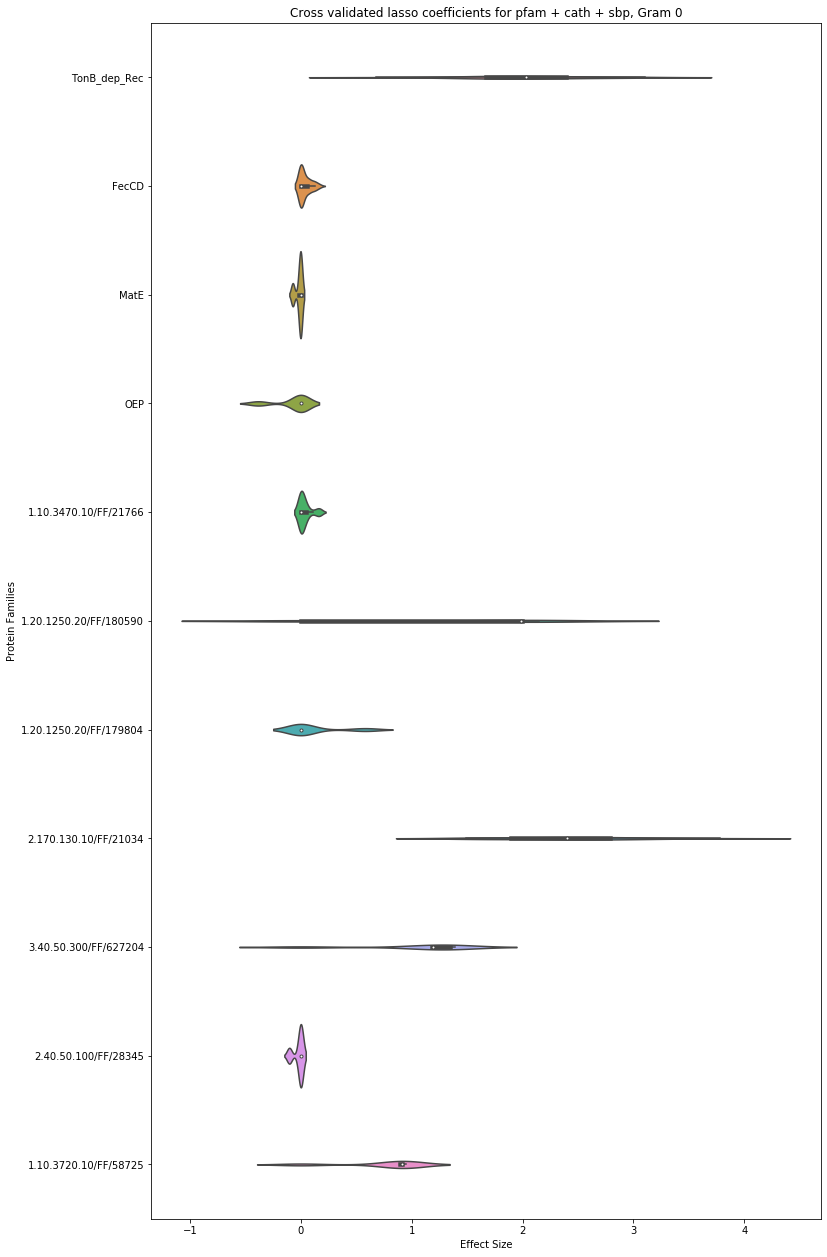

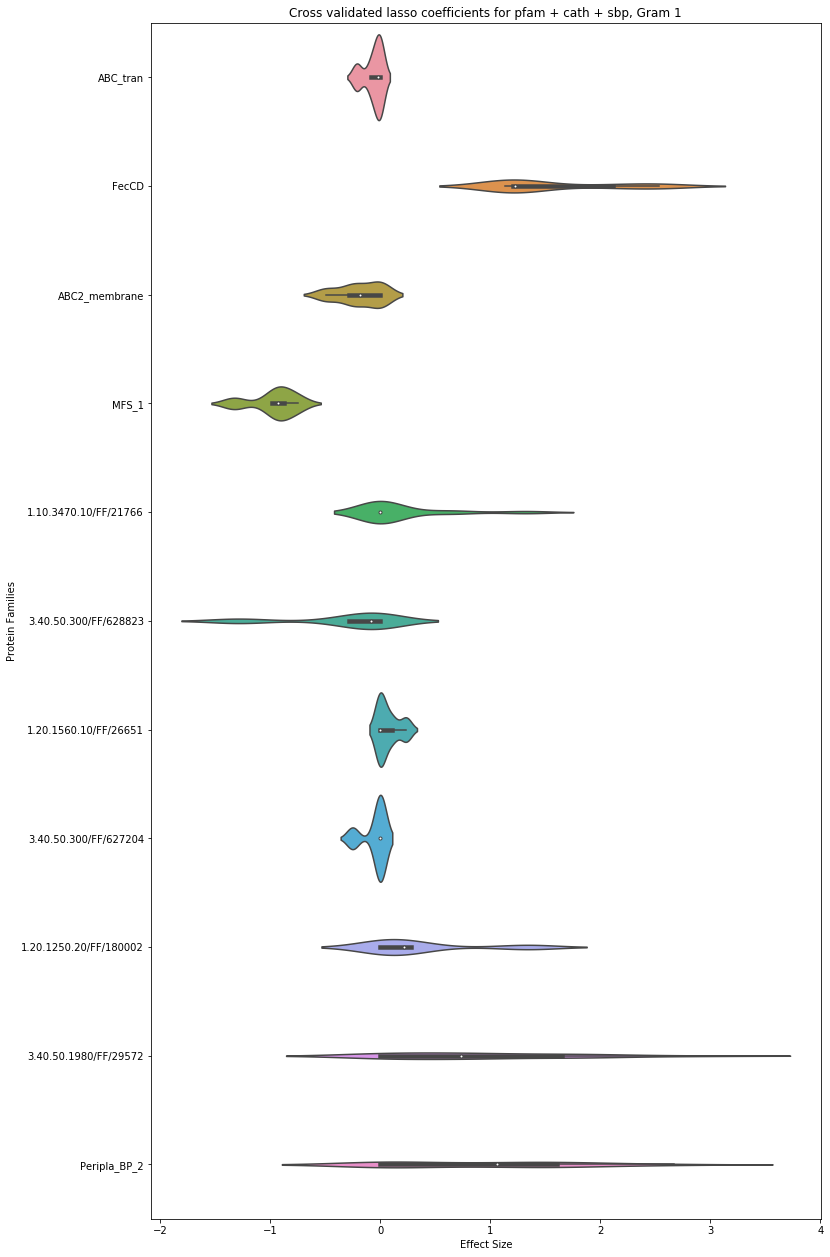

(('pfam',             BGC  ABC_tran  BPD_transp_1  TonB_dep_Rec  ABC_membrane  ACR_tran  \
0    BGC0000001         2             2             0             0         0   
2    BGC0000019         2             0             0             0         0   
4    BGC0000026         1             0             0             0         0   
5    BGC0000029         0             0             0             0         0   
8    BGC0000034         1             0             0             0         0   
..          ...       ...           ...           ...           ...       ...   
783  BGC0001861         1             0             0             1         0   
784  BGC0001863         1             0             0             1         0   
787  BGC0001872         1             0             0             0         0   
788  BGC0001877         1             0             0             0         0   
802  BGC0001939         0             0             0             0         0   

     FecCD  ABC2_

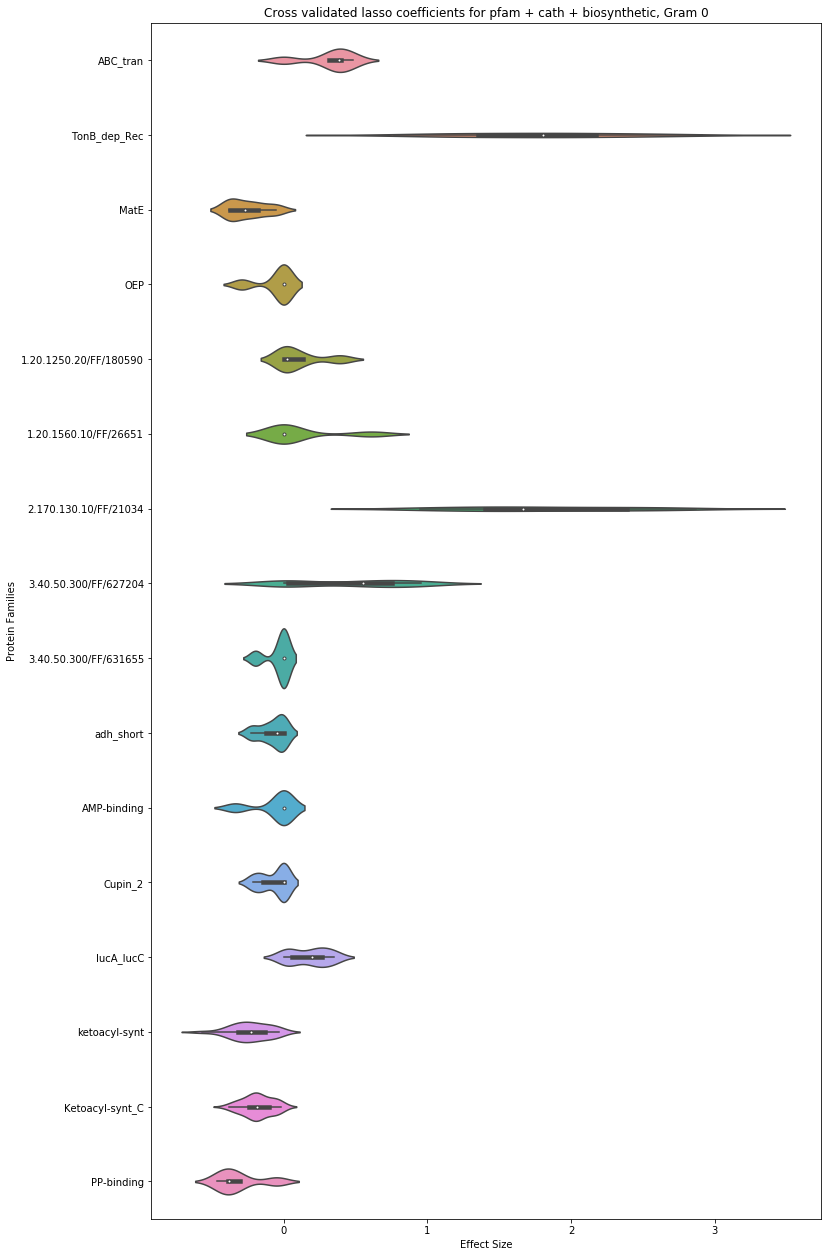

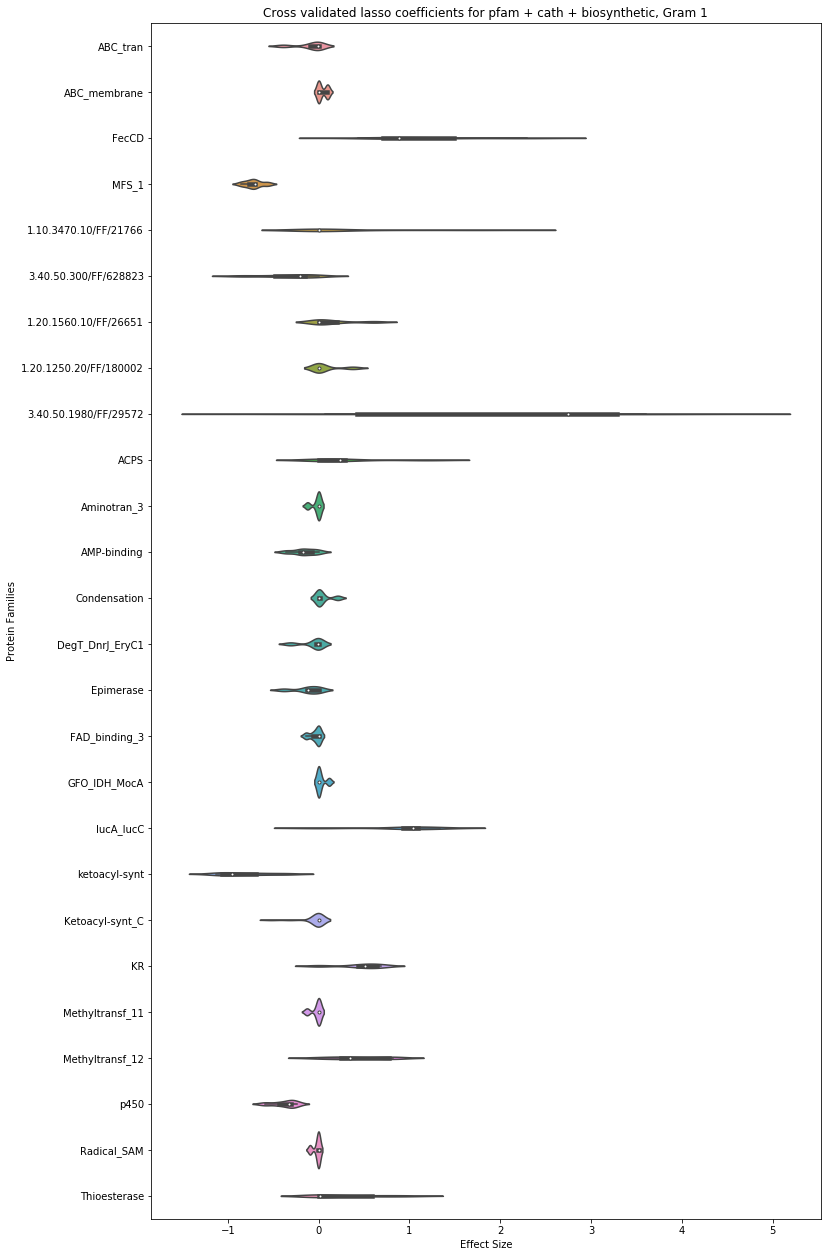

(('pfam',             BGC  ABC_tran  BPD_transp_1  TonB_dep_Rec  ABC_membrane  ACR_tran  \
0    BGC0000001         2             2             0             0         0   
2    BGC0000019         2             0             0             0         0   
4    BGC0000026         1             0             0             0         0   
5    BGC0000029         0             0             0             0         0   
8    BGC0000034         1             0             0             0         0   
..          ...       ...           ...           ...           ...       ...   
783  BGC0001861         1             0             0             1         0   
784  BGC0001863         1             0             0             1         0   
787  BGC0001872         1             0             0             0         0   
788  BGC0001877         1             0             0             0         0   
802  BGC0001939         0             0             0             0         0   

     FecCD  ABC2_

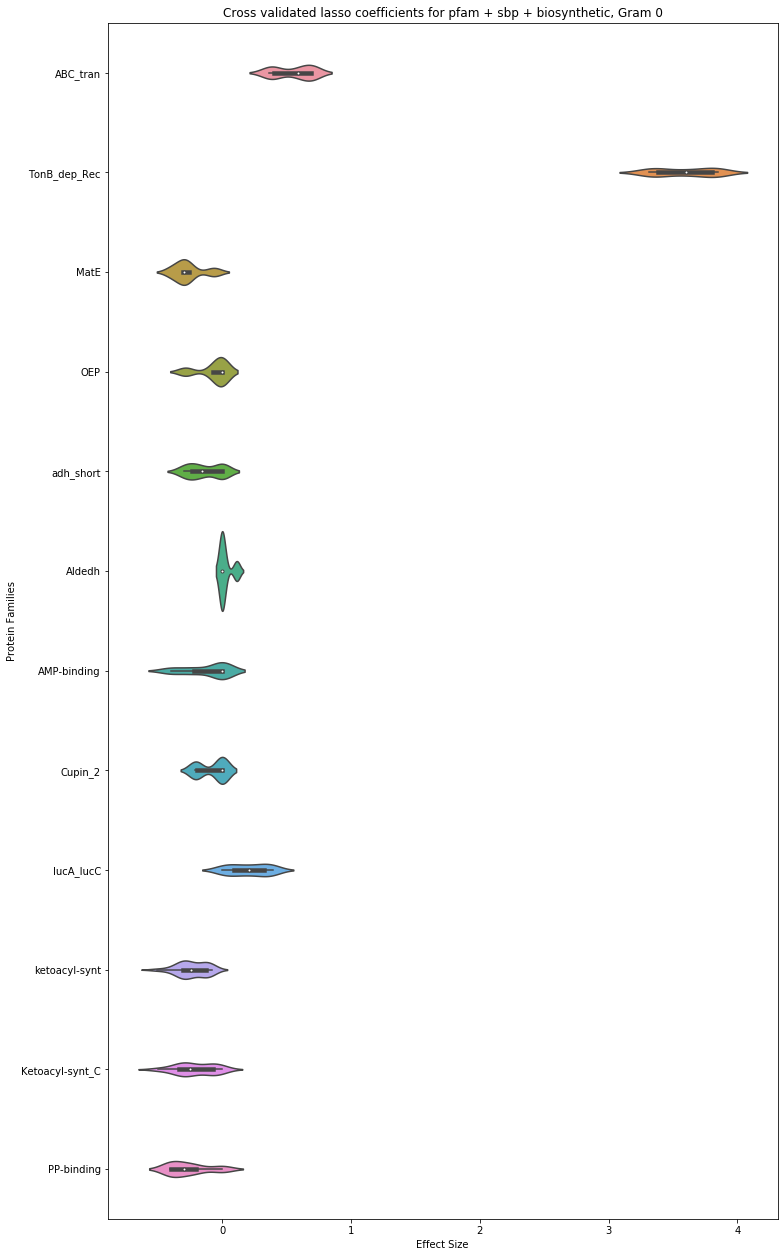

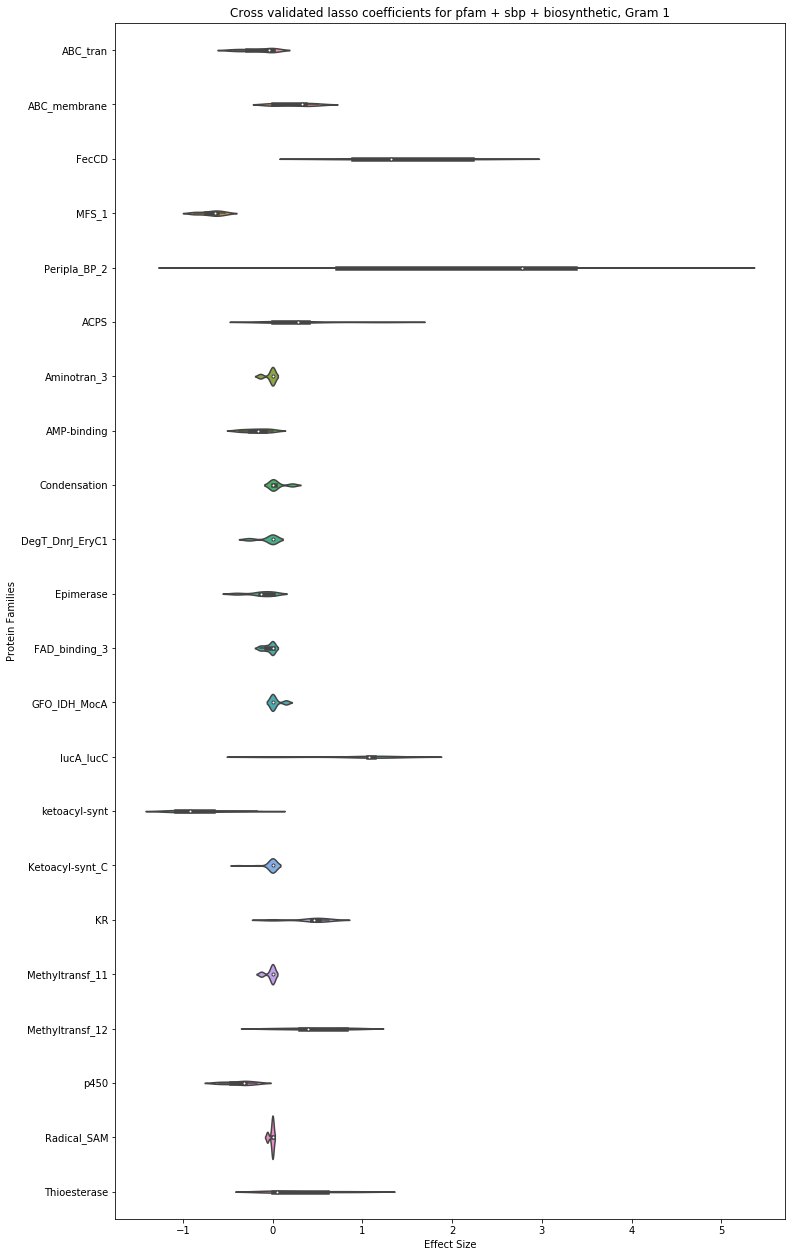

(('cath',             BGC  3.40.50.300/FF/632839  1.10.3470.10/FF/21766  \
0    BGC0000001                      0                      0   
2    BGC0000019                      0                      0   
4    BGC0000026                      0                      0   
5    BGC0000029                      0                      0   
8    BGC0000034                      0                      0   
..          ...                    ...                    ...   
783  BGC0001861                      0                      0   
784  BGC0001863                      0                      0   
787  BGC0001872                      0                      0   
788  BGC0001877                      0                      0   
802  BGC0001939                      0                      0   

     3.40.50.1980/FF/29562  1.20.1640.10/FF/24538  1.20.1250.20/FF/181070  \
0                        0                      0                       0   
2                        0                      0      

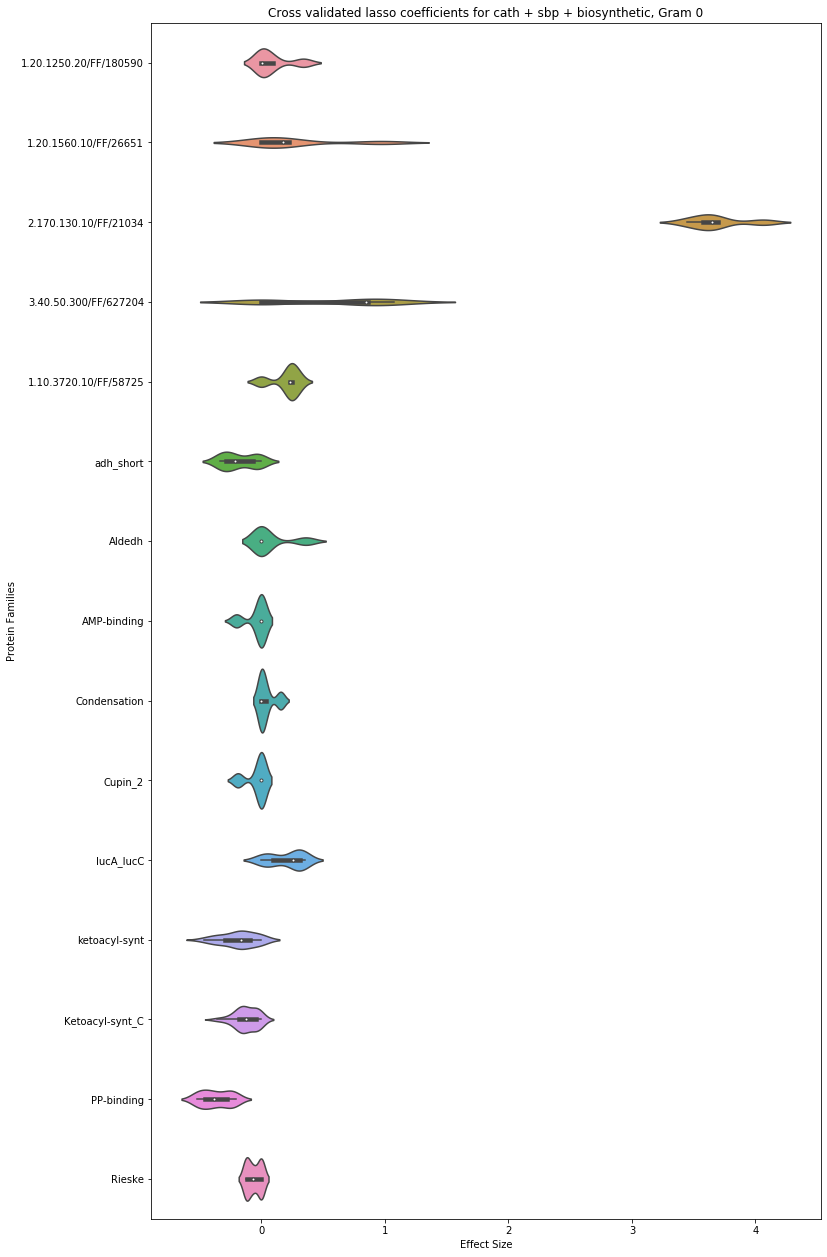

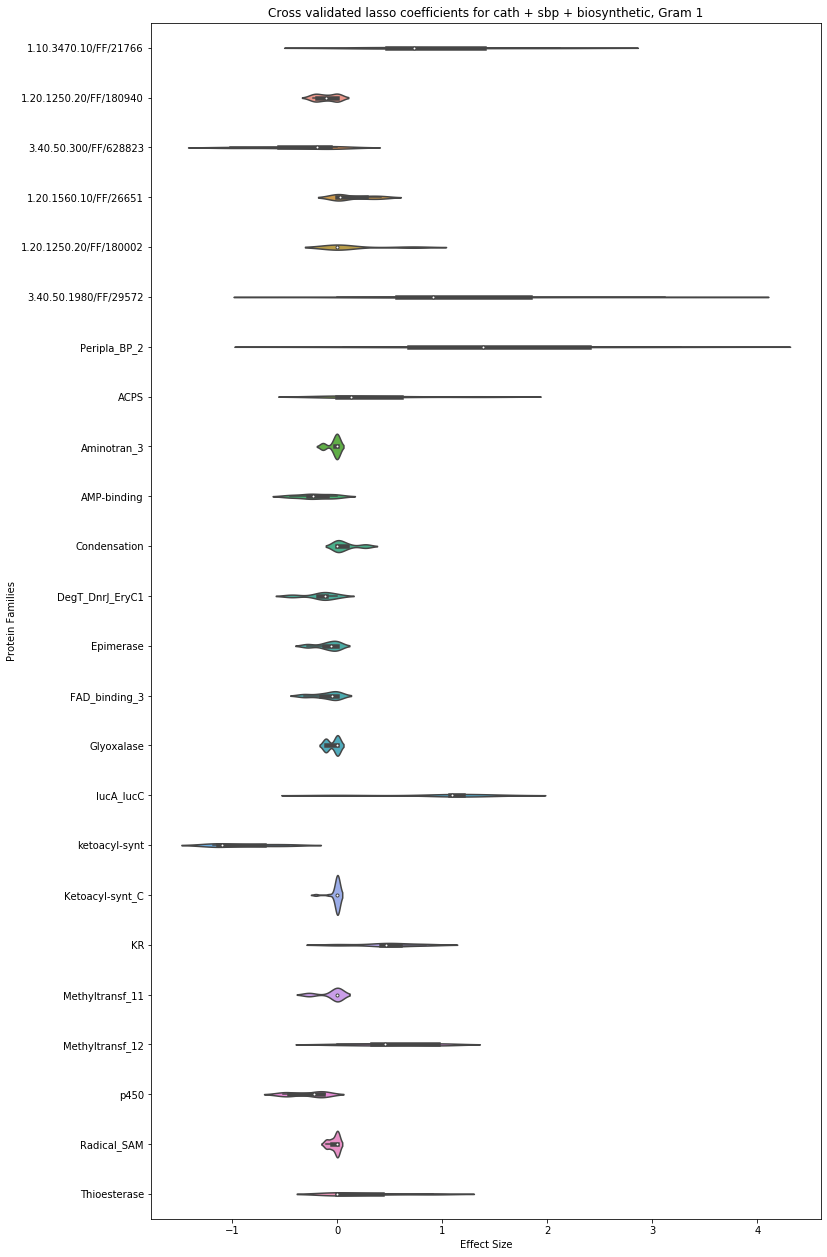

(('pfam',             BGC  ABC_tran  BPD_transp_1  TonB_dep_Rec  ABC_membrane  ACR_tran  \
0    BGC0000001         2             2             0             0         0   
2    BGC0000019         2             0             0             0         0   
4    BGC0000026         1             0             0             0         0   
5    BGC0000029         0             0             0             0         0   
8    BGC0000034         1             0             0             0         0   
..          ...       ...           ...           ...           ...       ...   
783  BGC0001861         1             0             0             1         0   
784  BGC0001863         1             0             0             1         0   
787  BGC0001872         1             0             0             0         0   
788  BGC0001877         1             0             0             0         0   
802  BGC0001939         0             0             0             0         0   

     FecCD  ABC2_

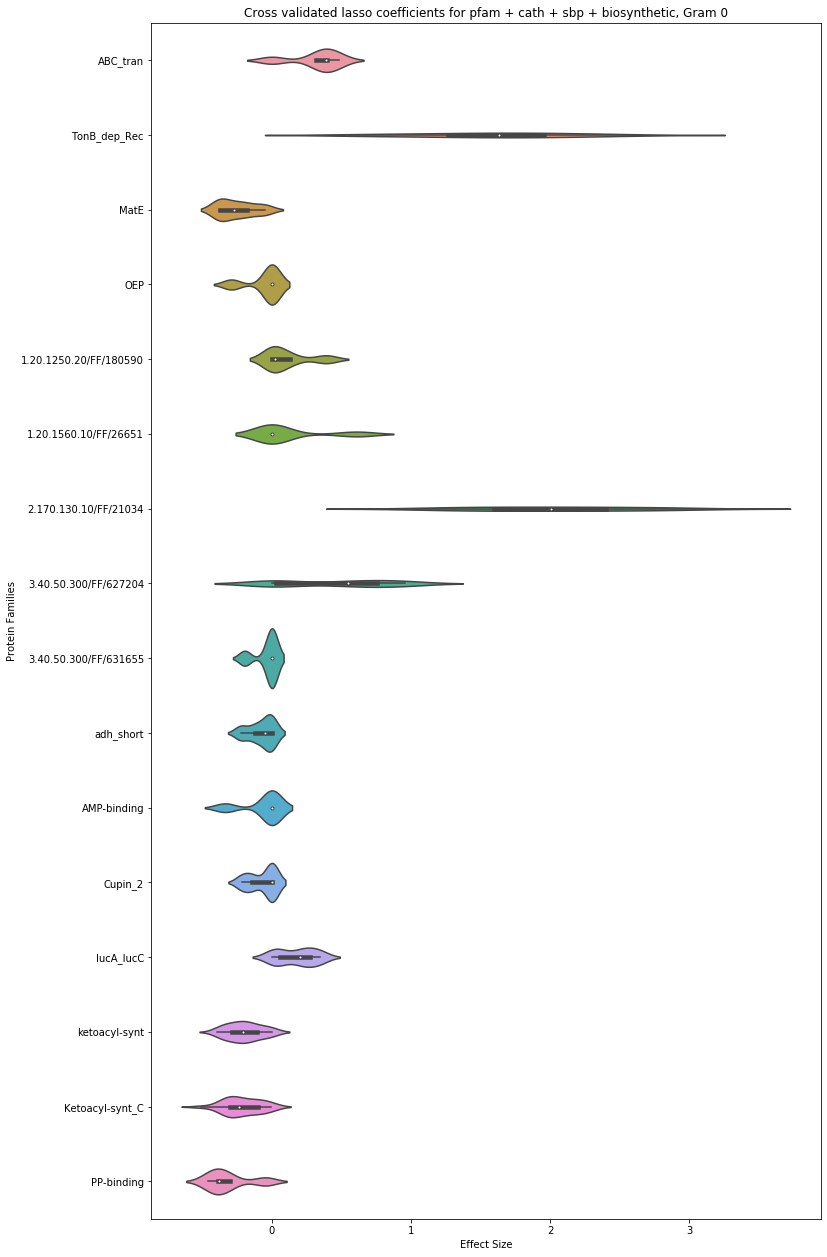

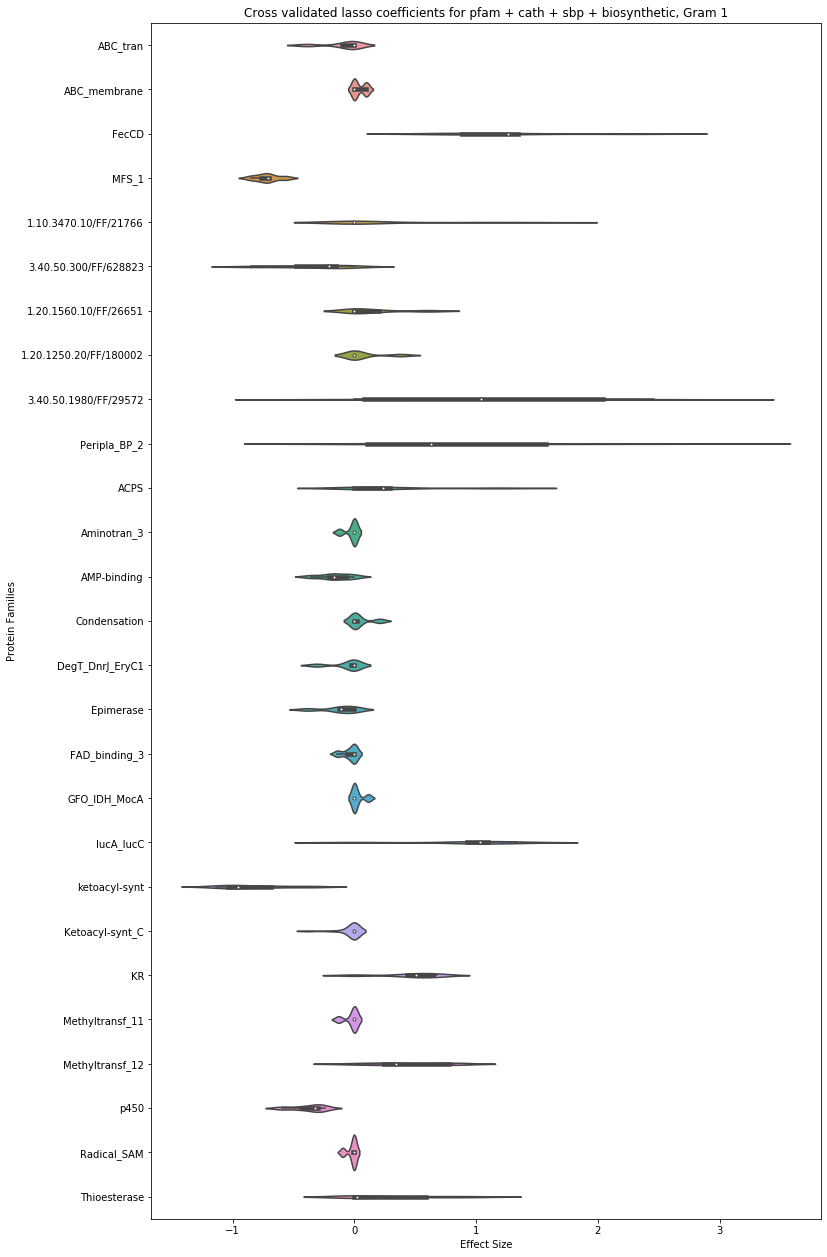

In [10]:
for subset in powerset(siderophore_data.items()):
    print(subset)
    if len(subset) == 0:
        continue
    
    # Subset is of the form ((key, data), (key, data), ...)
    # so we have to slice it.
    keys = [x[0] for x in subset] 
    df = [x[1].set_index('BGC') for x in subset]
    df = pd.concat(df, axis=1)

    # Bookkeeping: make BGC a column and remove duplications
    df = df.reset_index()
    df = df.loc[:, ~df.columns.duplicated()]

    names = ' + '.join(keys)
    features = df.columns.drop(['BGC', 'label', 'Gram'])
    
    for gram_type, d in df.groupby('Gram'):
        X, y = create_clf_data(d)
        title = f'Cross validated lasso coefficients for {names}, Gram {gram_type}'
        visualize_lasso_coeffs(X, y, classifiers['lasso'], features, title=title)